In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

## Loading and cleaning

In [19]:
# Loading data from GDrive.

# Data with BDL merged,
file_id = "13sffAPIl39xCvYpp2K1nCao2Yl9Plqmv"
url = f"https://drive.google.com/uc?id={file_id}"
file_extension = "downloaded_file.csv"
gdown.download(url, file_extension, quiet=False)
df = pd.read_csv(file_extension, sep=",")

Downloading...
From (original): https://drive.google.com/uc?id=13sffAPIl39xCvYpp2K1nCao2Yl9Plqmv
From (redirected): https://drive.google.com/uc?id=13sffAPIl39xCvYpp2K1nCao2Yl9Plqmv&confirm=t&uuid=b868d82b-5cf1-409b-acb7-299dbaced2b5
To: C:\Users\Konrad\Desktop\Magisterka\Kod\2024-mgr-sluzba-cywilna\Python\Code\downloaded_file.csv
100%|██████████| 257M/257M [00:03<00:00, 66.5MB/s] 


In [20]:
# Changing "," to "." in numerical variables.
comma_cols_to_replace = {
    'mediana_wieku': 'bdl_age_median',
    'wydatki_powiat': 'bdl_district_expenses',
    'wynagrodzenia': 'bdl_average_salary'
}

# Replace commas with dots and convert to float.
for old_col, new_col in comma_cols_to_replace.items():
    try:
        df[new_col] = df[old_col].str.replace(',', '.', regex=False).astype(float)
    except AttributeError:
        df[new_col] = df[old_col]
        continue

df.drop(columns=comma_cols_to_replace.keys(), inplace=True)

In [21]:
# Other columns to rename.
col_names_to_replace = {
    'cena_mieszkan': 'bdl_avg_house_pricing',
    'saldo_migracji': 'bdl_migration_coefficient',
    'wsp_feminizacji': 'bdl_feminization_coefficient'
}

for old_col, new_col in col_names_to_replace.items():
    df[new_col] = df[old_col].astype(float)
    df.drop([old_col], axis=1, inplace=True)

## Imputation

In [22]:
# Imputing values for salary_for_position, since this variable has relatively low variance and is potentially of greater importance.

df_for_imputation = df.groupby(['district', 'voivodeship', 'institution', 'year', 'position_category'])['salary_for_position'].agg('mean').reset_index()
df_for_imputation = df_for_imputation[df_for_imputation["salary_for_position"].notnull()]
df_for_imputation["median"] = df_for_imputation["salary_for_position"].median()

df_for_imputation = df[df['salary_for_position'].notnull()]

df_for_imputation = (
    df_for_imputation
    .groupby(['district', 'voivodeship', 'institution', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median'})
)

df = df.merge(df_for_imputation, on=['district', 'voivodeship', 'institution', 'year', 'position_category'], how='left')
df['salary_for_position'] = df['salary_for_position'].fillna(df['median'])
df = df.drop(columns=['median'])

In [23]:
# The previous imputation didn't solve the issue completely,
# since for some institutions there was no data about salary at all.


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100937 entries, 0 to 100936
Data columns (total 34 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ad_id                         100937 non-null  int64  
 1   result                        100937 non-null  int64  
 2   job_field                     100937 non-null  object 
 3   position_category             100937 non-null  object 
 4   position                      100937 non-null  object 
 5   education_level               100937 non-null  int64  
 6   work_time                     100928 non-null  float64
 7   vacancies                     100937 non-null  int64  
 8   city                          100937 non-null  object 
 9   institution                   100937 non-null  object 
 10  workplace                     100937 non-null  object 
 11  department                    100937 non-null  object 
 12  institution_address           100937 non-nul

In [25]:
df['position_category'].value_counts()

position_category
stanowiska specjalistyczne     46571
stanowiska wspomagające        32350
stanowiska samodzielne         19878
stanowiska koordynujące         1415
średni szczebel zarządzania      673
wyższe stanowiska                 50
Name: count, dtype: int64

In [26]:
temp_df = df[df["position_category"] == "średni szczebel zarządzania"]
temp_df.head(10000)

,ad_id,result,job_field,position_category,position,education_level,work_time,vacancies,city,institution,...,fluctuation,employment_contract,voivodeship,district,bdl_age_median,bdl_district_expenses,bdl_average_salary,bdl_avg_house_pricing,bdl_migration_coefficient,bdl_feminization_coefficient
9,130808,1,law,średni szczebel zarządzania,główny księgowy,1,1.00,1,Kamień Pomorski,Komenda Powiatowa Państwowej Straży Pożarnej w...,...,0.000000,NaN,32,7,45.4,1864.63,6058.19,13194.0,-60.0,105.0
157,130048,1,law,średni szczebel zarządzania,główny księgowy,1,0.50,1,Krosno,Powiatowy Inspektorat Nadzoru Budowlanego dla ...,...,0.000000,NaN,18,61,45.4,NaN,6135.13,5761.0,-118.0,112.0
295,129881,1,law,średni szczebel zarządzania,główny księgowy,1,0.25,1,Mogilno,Powiatowy Inspektorat Nadzoru Budowlanego w Mo...,...,0.307692,NaN,4,9,43.1,2604.80,6386.99,4045.0,-104.0,104.0
579,129403,1,law,średni szczebel zarządzania,główny księgowy,3,1.00,1,Gorzów Wielkopolski,Regionalna Dyrekcja Ochrony Środowiska w Gorzo...,...,0.075000,NaN,8,61,44.9,NaN,6713.76,6125.0,-350.0,113.0
607,129349,0,law,średni szczebel zarządzania,główny księgowy,2,1.00,1,Warszawa,Kuratorium Oświaty w Warszawie,...,0.123630,NaN,14,65,41.2,NaN,9625.74,13081.0,6224.0,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100285,18912,1,law,średni szczebel zarządzania,główny księgowy,3,0.50,1,Bochnia,Powiatowy Inspektorat Nadzoru Budowlanego w Bo...,...,NaN,NaN,12,1,NaN,996.98,3783.80,4255.0,-27.0,103.0
100397,18802,1,law,średni szczebel zarządzania,zastępca głównego księgowego,3,1.00,1,Gorzów Wielkopolski,Powiatowy Inspektorat Weterynarii w Gorzowie W...,...,NaN,NaN,8,61,NaN,NaN,3934.20,3388.0,-32.0,110.0
100452,18729,1,law,średni szczebel zarządzania,główny księgowy,1,0.50,1,Ożarów Mazowiecki,Powiatowy Inspektorat Weterynarii Powiatu Wars...,...,NaN,NaN,14,32,NaN,1133.72,5054.09,4731.0,788.0,108.0
100528,18648,0,law,średni szczebel zarządzania,główny księgowy,3,1.00,1,Opole,Opolski Urząd Wojewódzki w Opolu,...,NaN,NaN,16,61,NaN,NaN,4615.56,4357.0,78.0,112.0


## Feature engineering

In [27]:
df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)
df['offer_salary_mentioned'] = df['offer_salary'].notna().astype(int)

C:\Users\Konrad\AppData\Local\Temp\ipykernel_18216\2997230914.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)


In [28]:
df["len_requirements"] = df["requirements"].str.len()
df["len_nice_to_have"] = df["nice_to_have"].str.len()
df["len_responsibilities"] = df["responsibilities"].str.len()

In [29]:
# Dropping cols unnecessary for statistical analyses.
string_cols_for_temporary_dropping = [
    'ad_id',
    'institution_address',
    'workplace',
    'department',
    'responsibilities',
    'requirements',
    'offer_salary',
    'date_announced',
    'nice_to_have',
    'institution_address',
    'workplace',
    'department',
    'city',
    'position'
]
df = df.drop(string_cols_for_temporary_dropping, axis=1)

In [30]:
# Dealing with categorical columns.
df = pd.get_dummies(df, columns=['position_category', 'job_field'], drop_first=True)

## Analyses

In [31]:
# Aggregating data to institution-level.
df_institution_level = df.groupby(['district', 'voivodeship', 'institution']).agg('mean').reset_index()
df_institution_year_level = df.groupby(['district', 'voivodeship', 'institution', 'year']).agg('mean').reset_index()

In [32]:
# Variable correlation
numerical_columns_df = df[[
    'work_time',
    'ad_views',
    'applicants',
    'offer_salary_mentioned',
    'salary_for_position',
    'women_percentage',
    'bdl_feminization_coefficient',
    'fluctuation',
    'employment_contract',
    'bdl_avg_house_pricing',
    'bdl_age_median',
    'bdl_migration_coefficient',
    'bdl_district_expenses',
    'bdl_average_salary',
    'offer_salary_mentioned',
    'vacancies',
    'len_requirements',
    'len_nice_to_have',
    'len_responsibilities',
    'result'
]]


correlation = numerical_columns_df.corr()['result']

# Display the correlation matrix
print(correlation)

work_time                      -0.006441
ad_views                        0.229938
applicants                      0.332265
offer_salary_mentioned          0.058654
salary_for_position            -0.118788
women_percentage                0.022074
bdl_feminization_coefficient   -0.011286
fluctuation                    -0.064555
employment_contract             0.082224
bdl_avg_house_pricing          -0.090057
bdl_age_median                  0.020862
bdl_migration_coefficient      -0.056306
bdl_district_expenses          -0.080273
bdl_average_salary             -0.096934
offer_salary_mentioned          0.058654
vacancies                       0.067369
len_requirements               -0.068183
len_nice_to_have                0.000893
len_responsibilities           -0.103576
result                          1.000000
Name: result, dtype: float64


In [33]:
df_institution_level.describe()

,district,voivodeship,result,education_level,work_time,vacancies,ad_views,year,advertised_institution,applicants,...,job_field_documents,job_field_environment,job_field_law,job_field_other,job_field_other_manager,job_field_pharmacy/chemistry,job_field_tech/construction,job_field_uniformed services,job_field_vet,job_field_water
count,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,2438.000000,2684.000000,...,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000
mean,34.183187,17.207654,0.745041,2.306108,0.969204,1.079052,2134.599600,2020.395308,0.719736,8.695131,...,0.195348,0.025563,0.457401,0.050789,0.019275,0.013228,0.034139,0.063468,0.097505,0.004510
std,26.693492,9.262658,0.273657,0.735791,0.088392,0.228431,634.418773,1.142375,0.418251,8.456984,...,0.326806,0.125419,0.401998,0.186338,0.089346,0.104092,0.145580,0.202831,0.279280,0.060269
min,1.000000,2.000000,0.000000,1.000000,0.250000,1.000000,262.000000,2017.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,10.000000,0.545455,2.000000,0.989446,1.000000,1720.571429,2019.687500,0.333333,2.997808,...,0.000000,0.000000,0.032655,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,18.000000,0.826087,2.166667,1.000000,1.000000,2107.000000,2020.400000,1.000000,5.797436,...,0.000000,0.000000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,62.000000,24.000000,1.000000,2.893939,1.000000,1.050000,2490.562500,2021.000000,1.000000,12.155904,...,0.267568,0.000000,0.921017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,79.000000,32.000000,1.000000,4.000000,1.333333,4.333333,11287.000000,2023.000000,1.000000,69.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


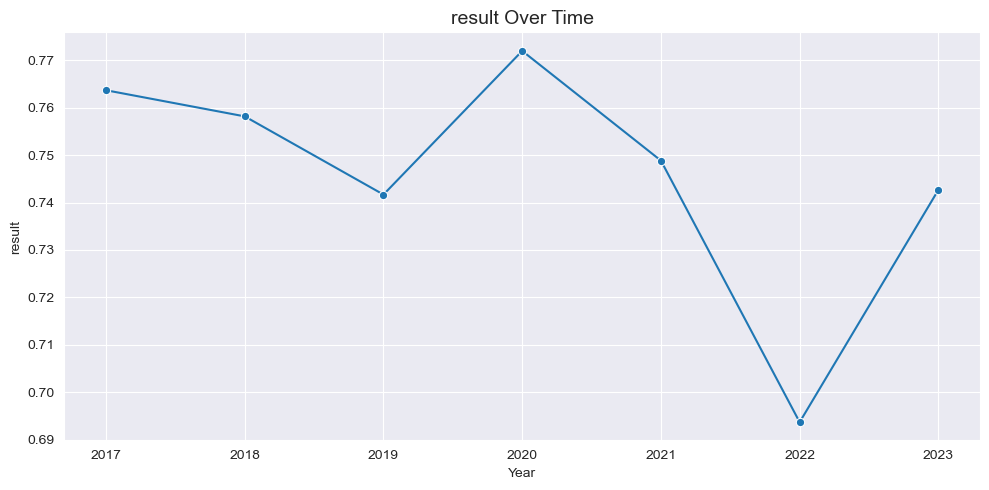

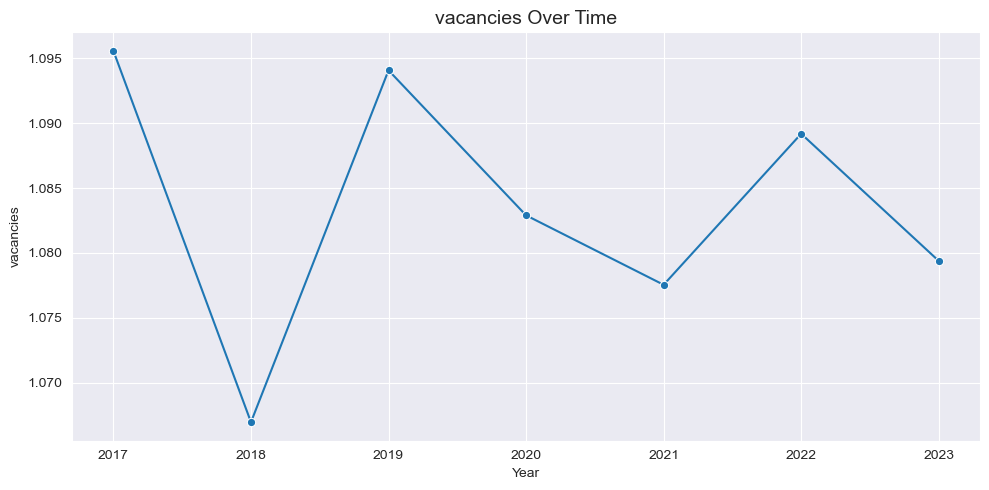

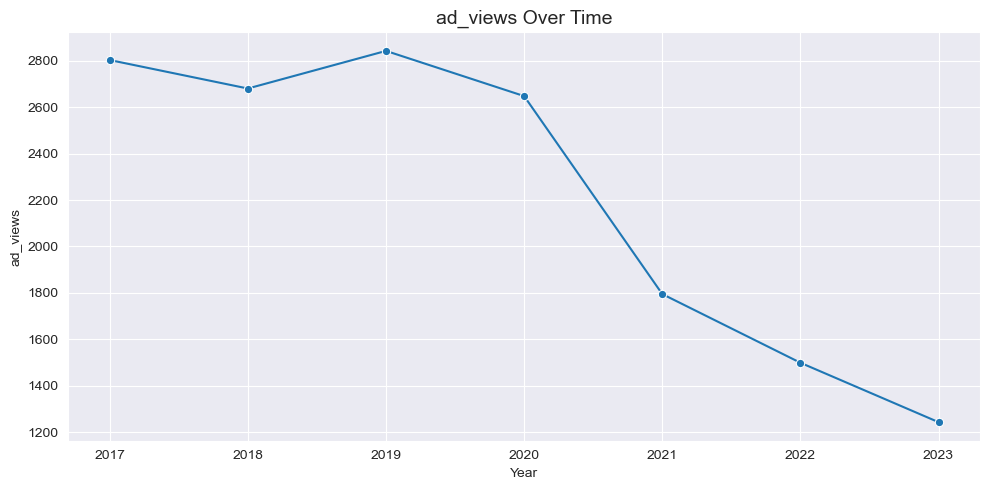

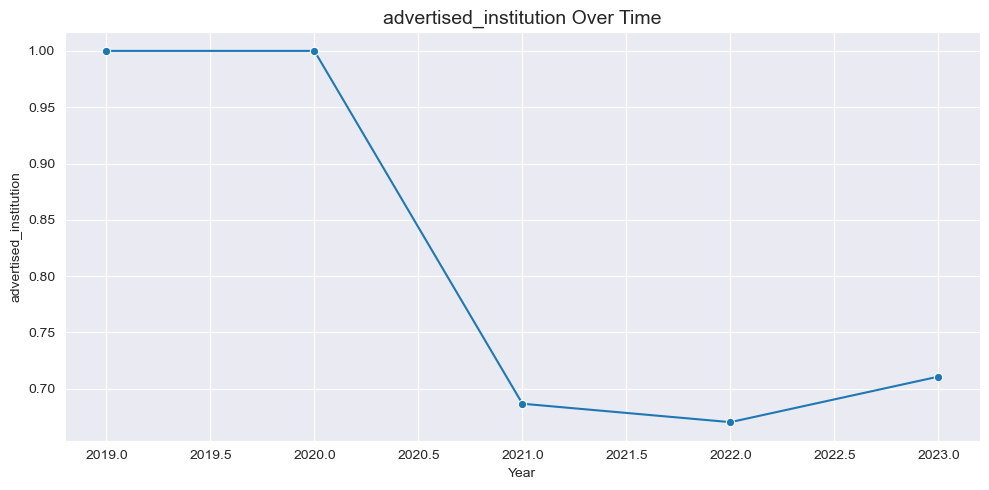

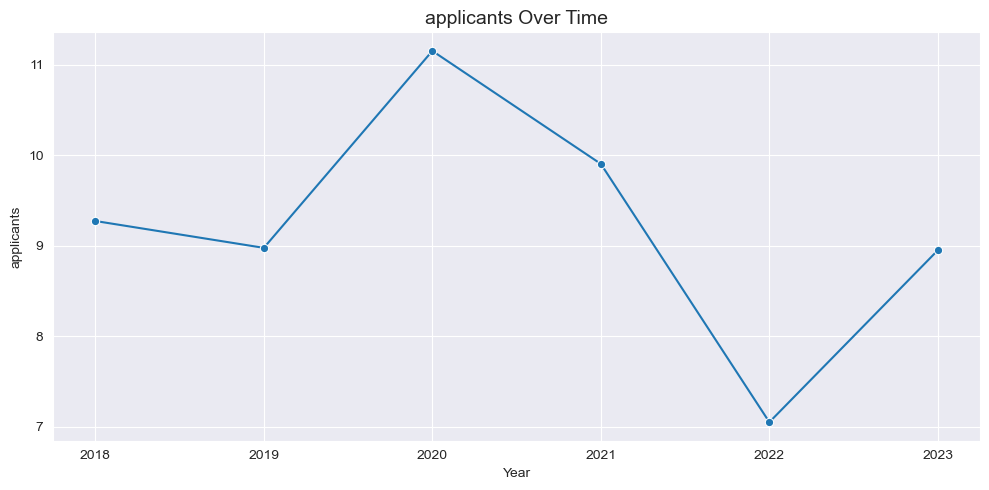

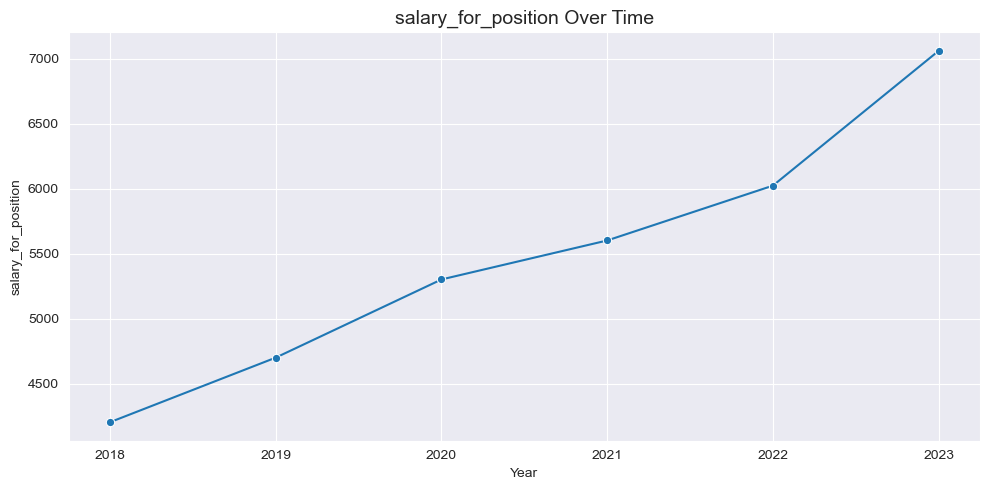

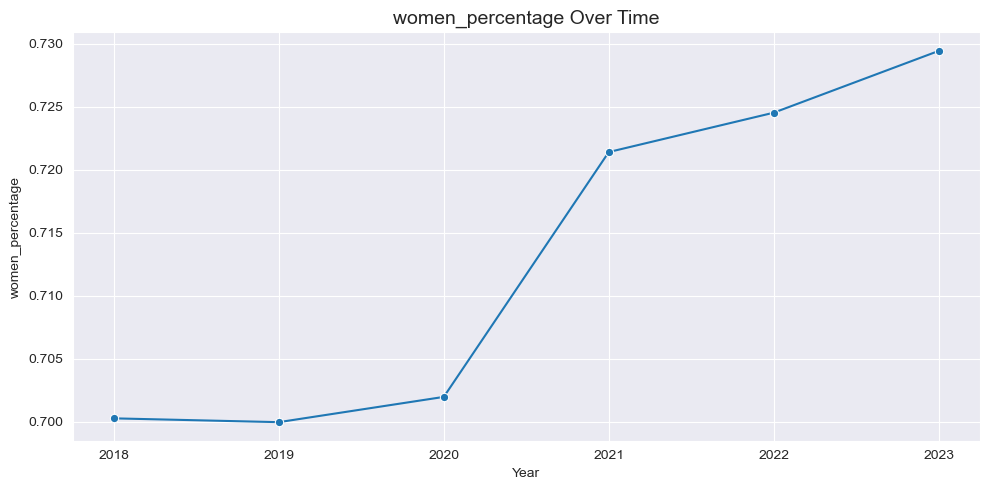

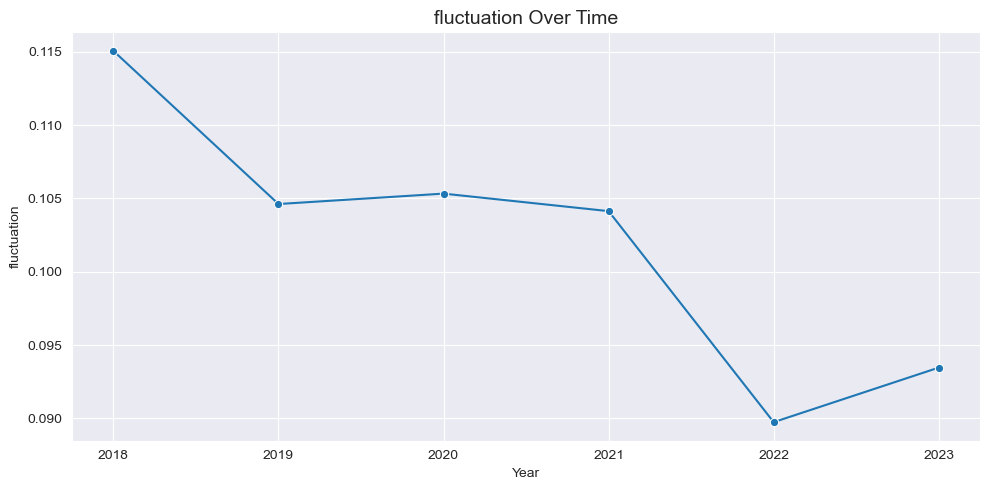

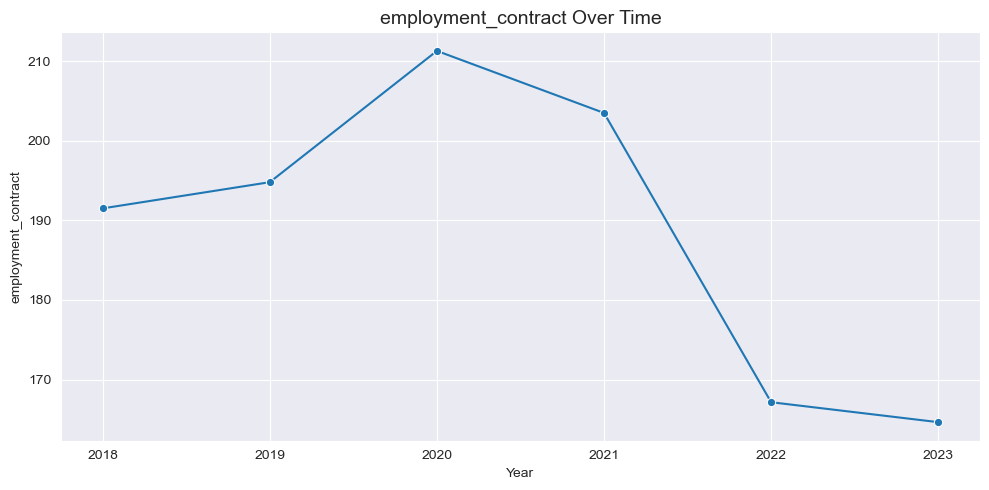

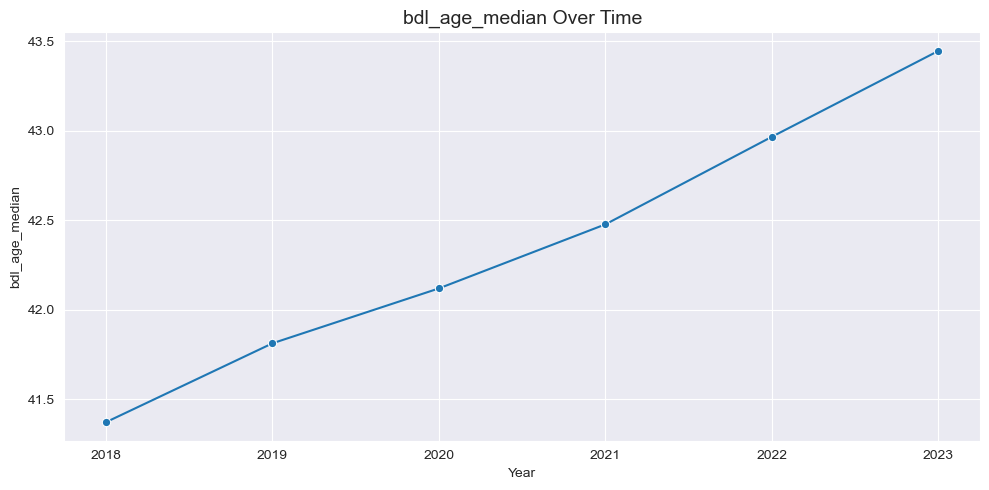

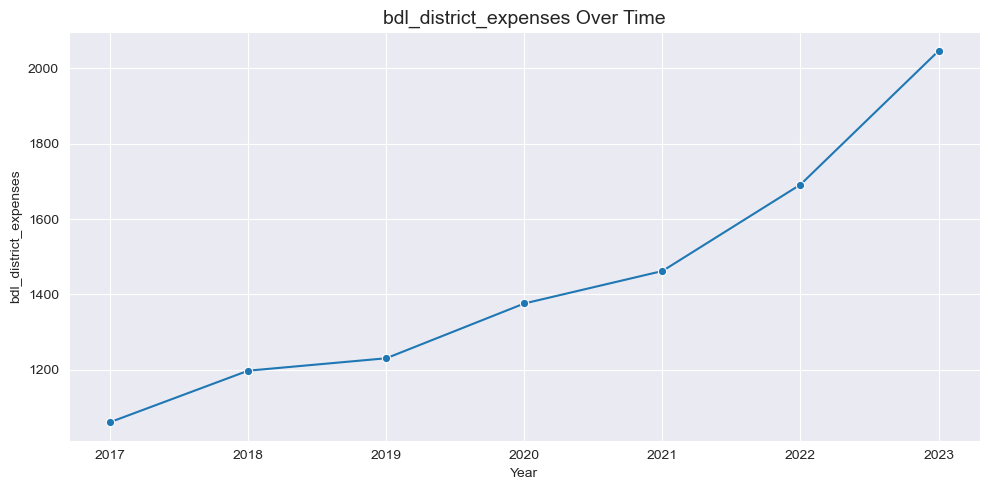

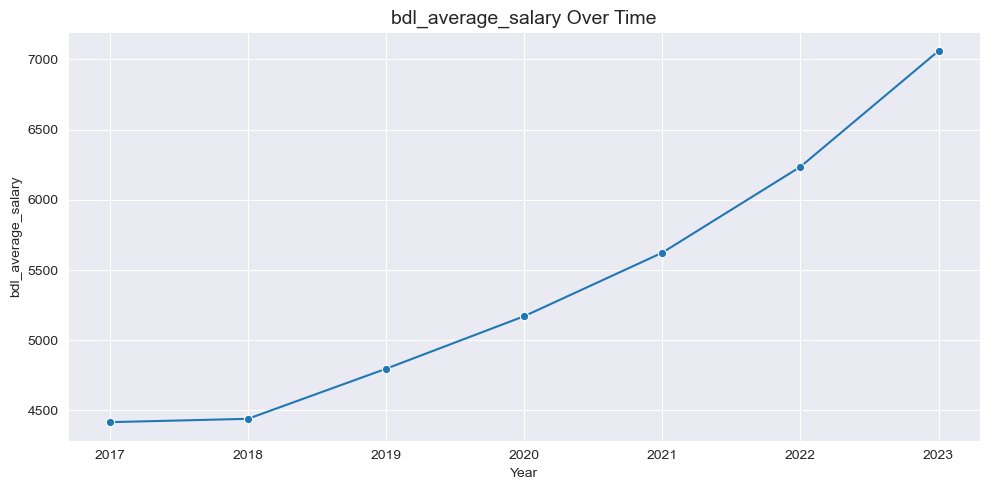

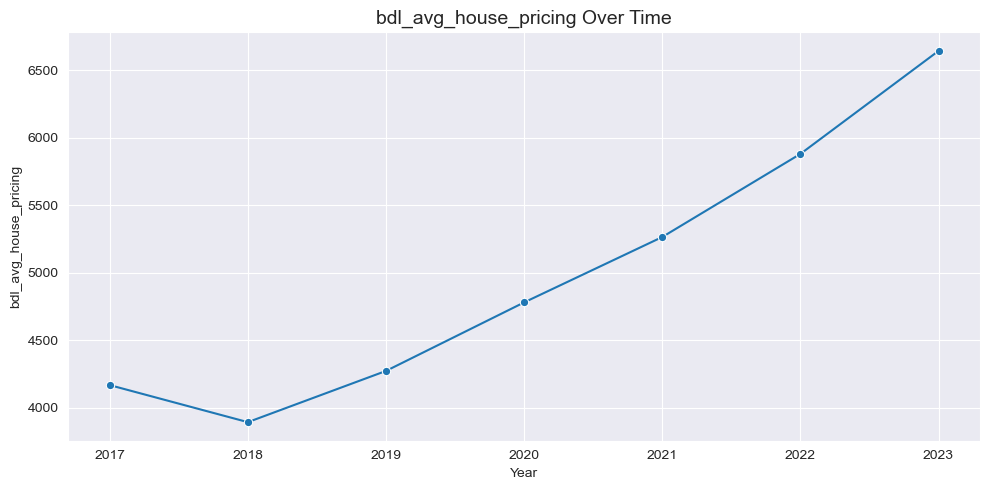

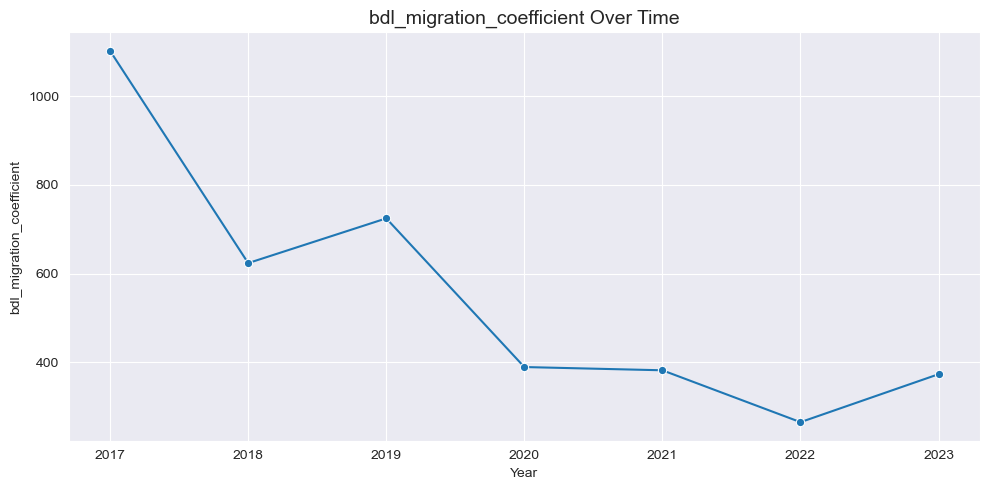

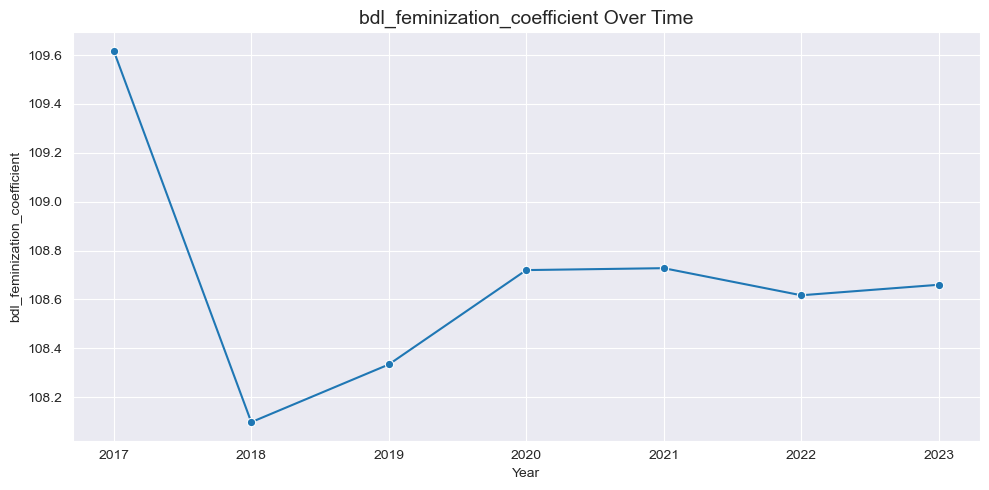

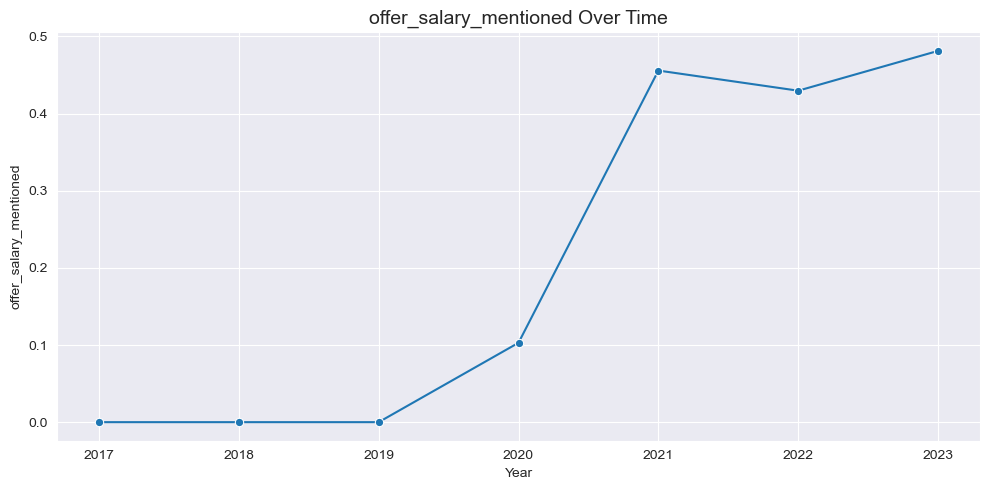

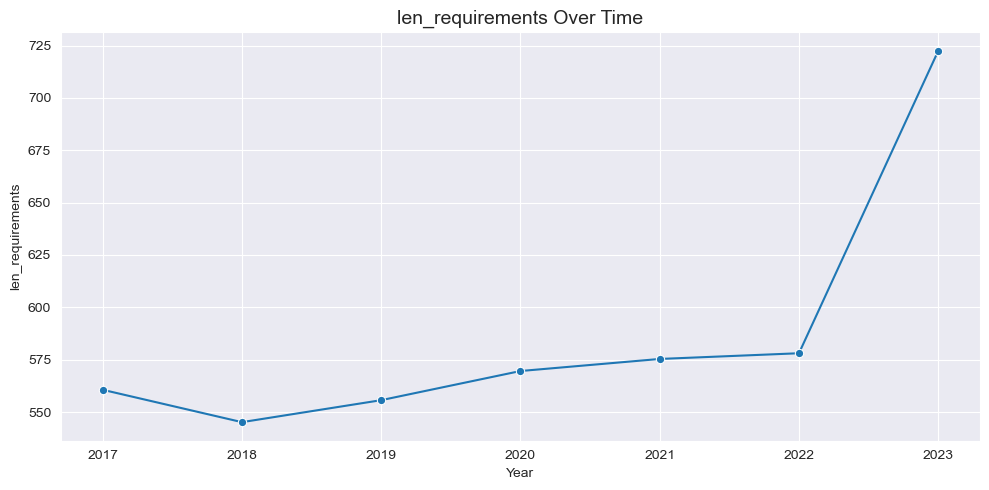

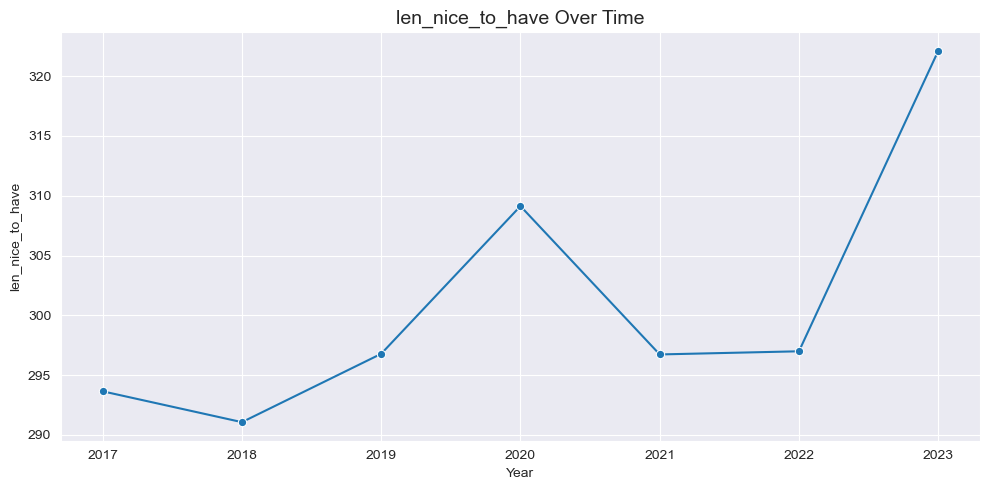

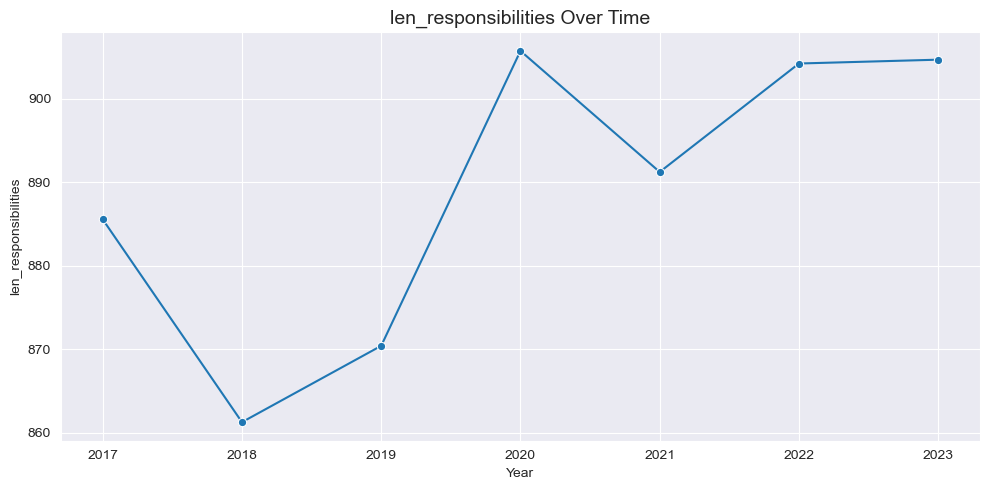

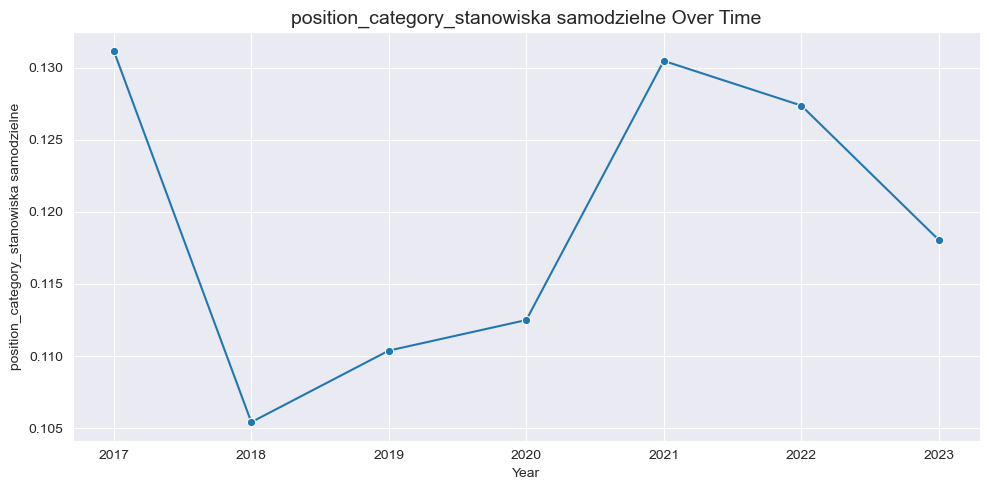

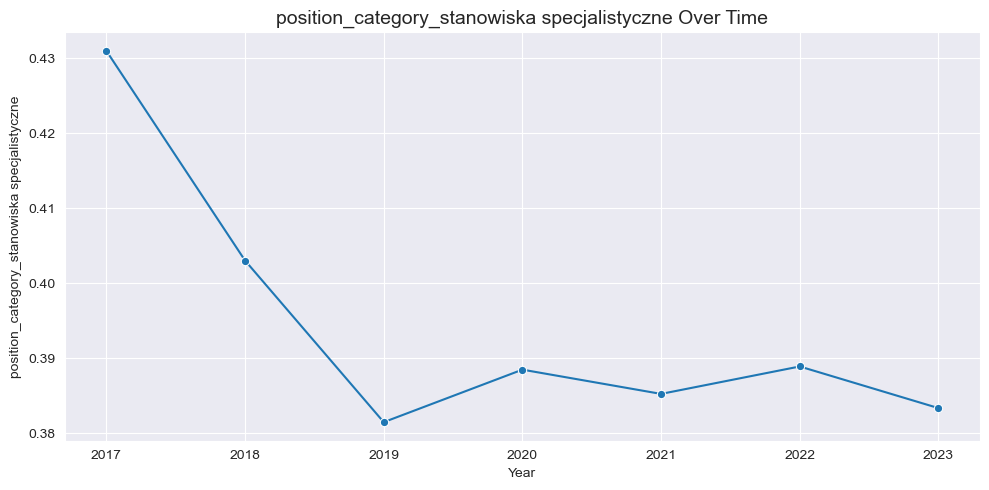

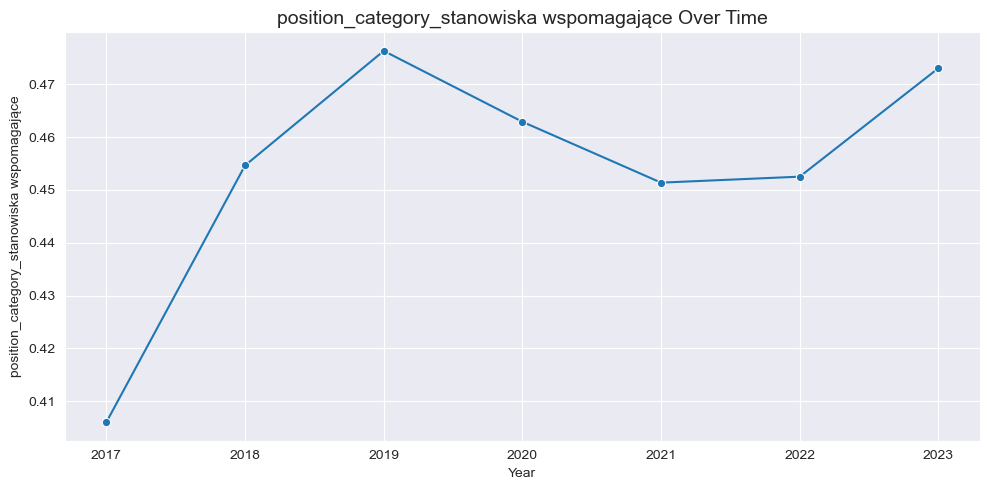

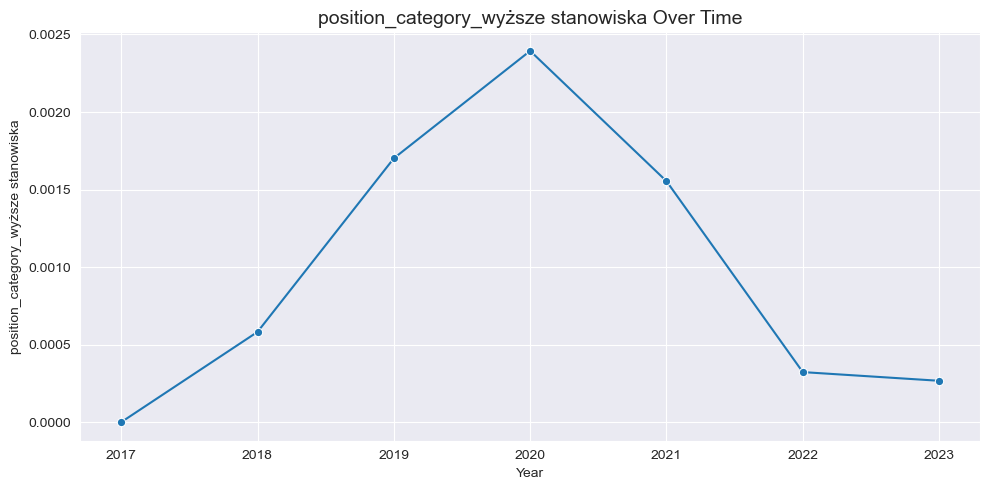

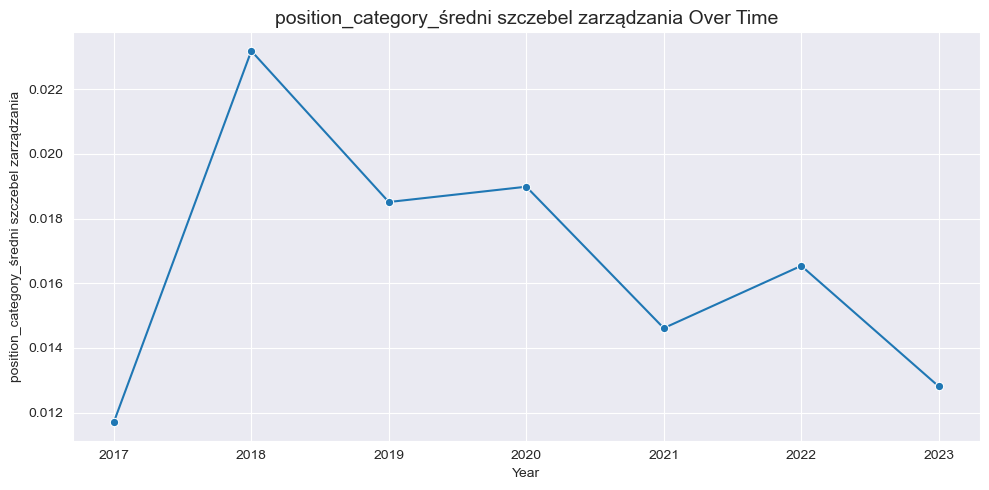

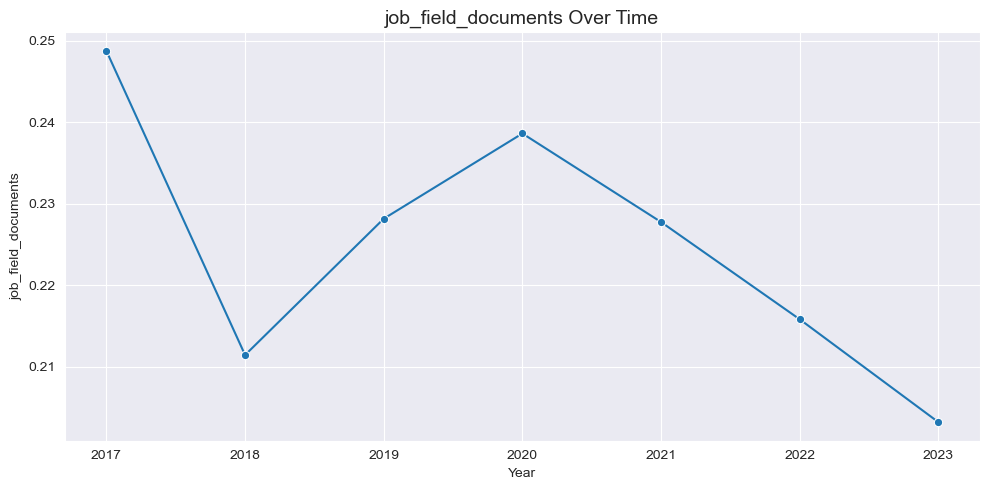

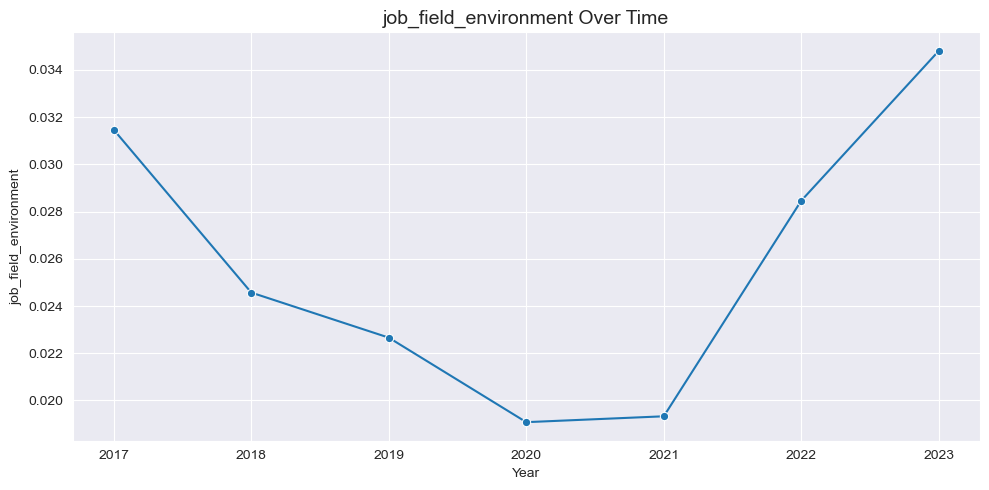

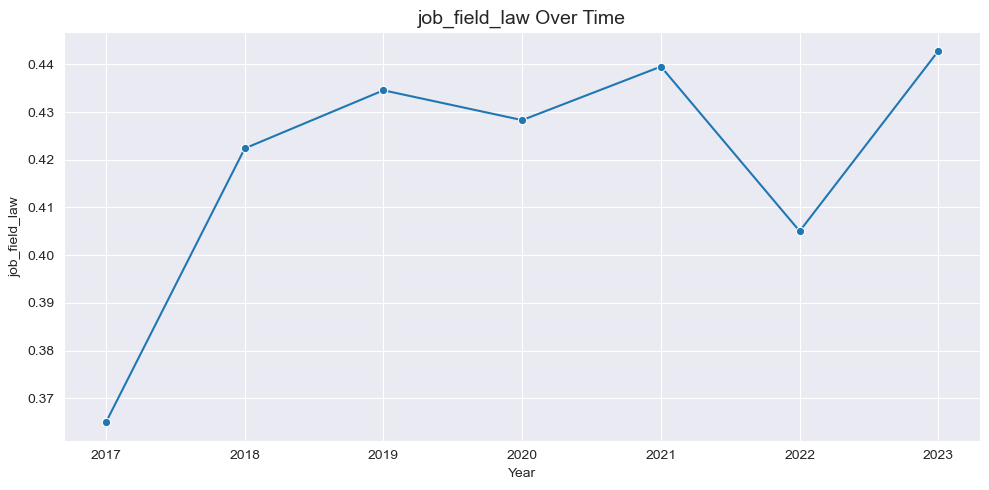

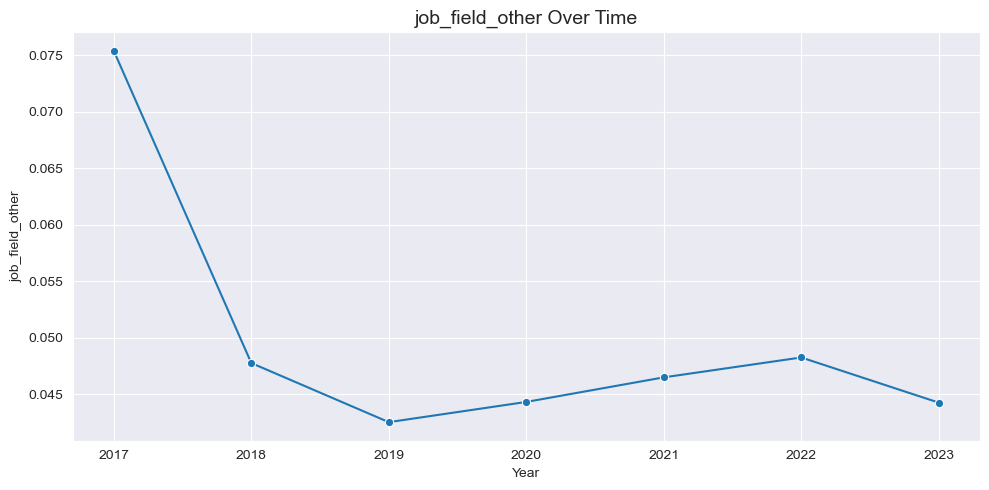

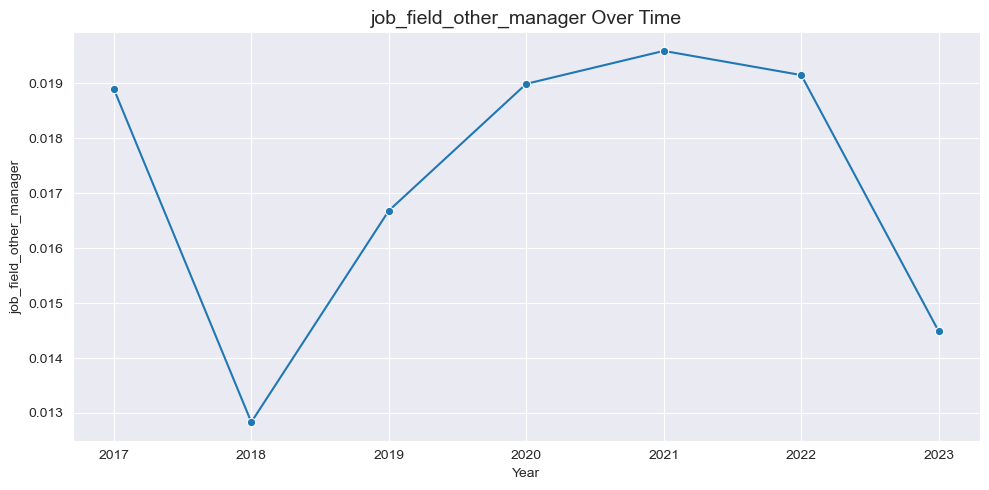

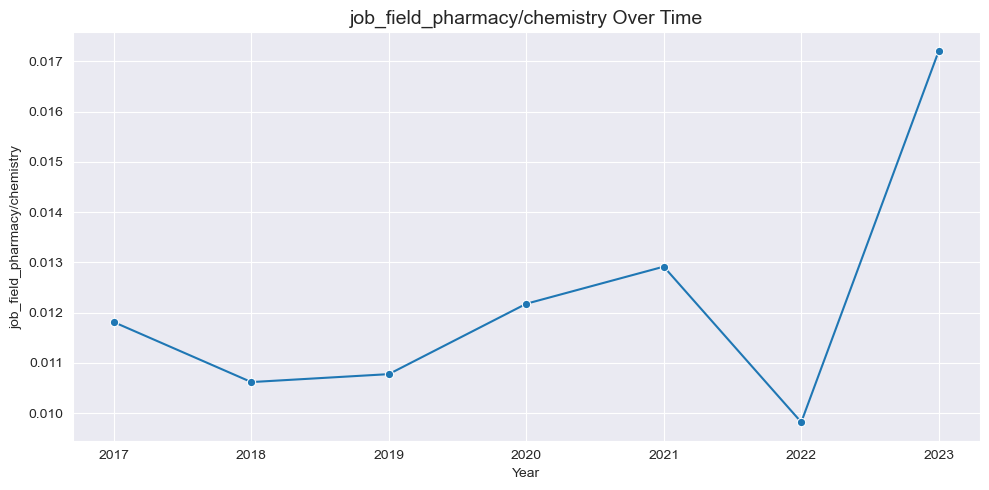

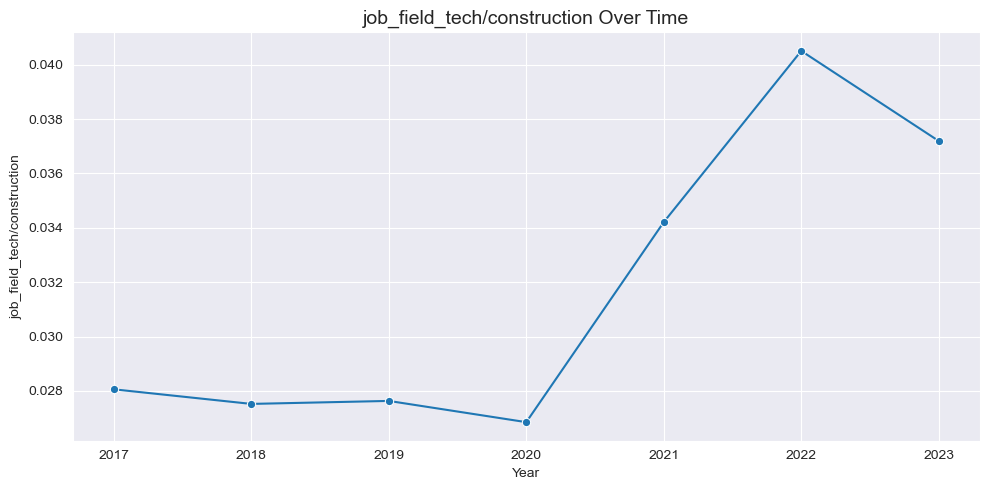

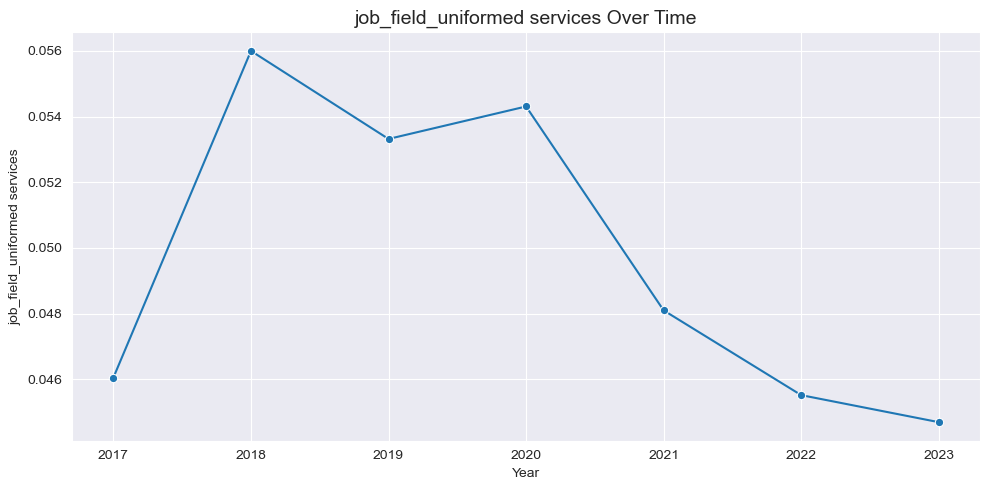

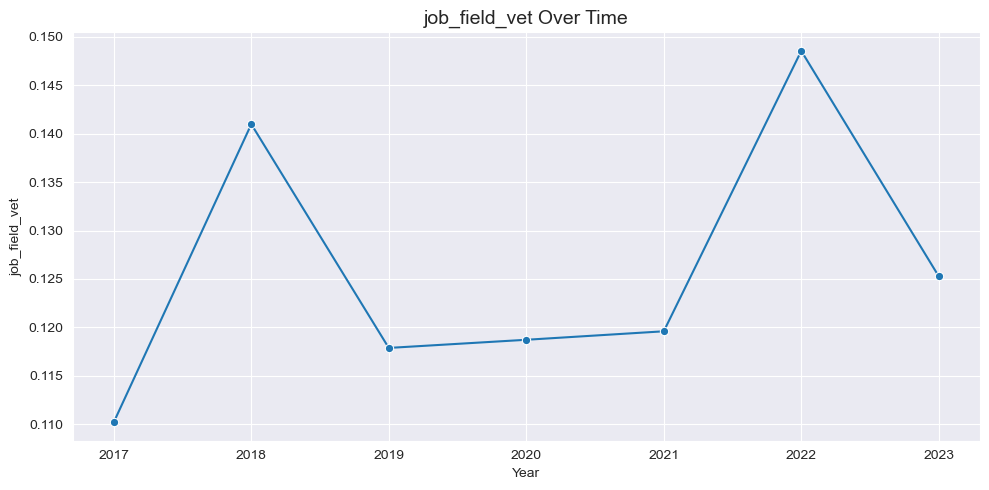

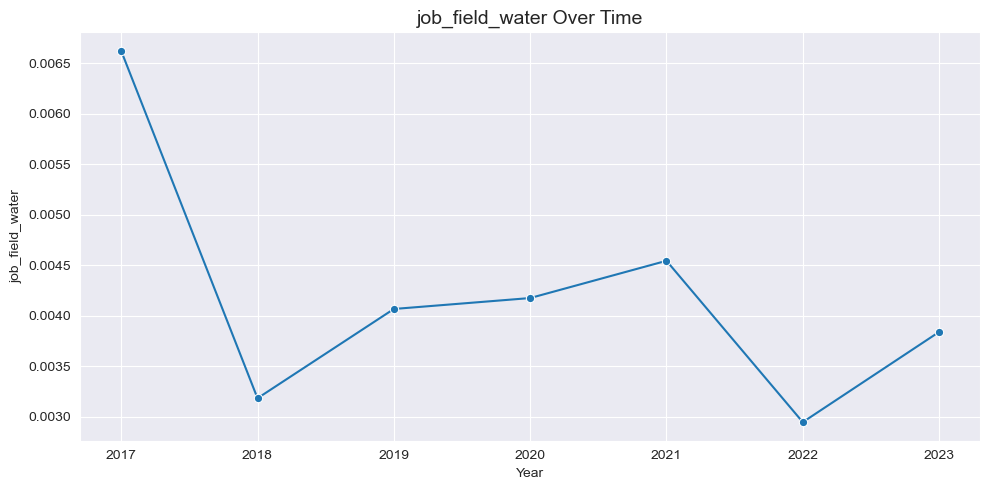

In [34]:
def plot_individual_time_series(dataframe):
    # Columns to exclude from plotting
    exclude_columns = ['voivodeship', 'district', 'education_level', 'work_time', 'institution']

    # Group by year and compute mean for numeric columns only.
    df_grouped = dataframe.groupby('year').mean(numeric_only=True)

    # Drop the excluded columns (if they exist).
    columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]

    # Plot each column individually
    for column in columns_to_plot:
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o')
        plt.title(f"{column} Over Time", fontsize=14)
        plt.xlabel("Year")
        plt.ylabel(column)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_individual_time_series(df_institution_year_level)

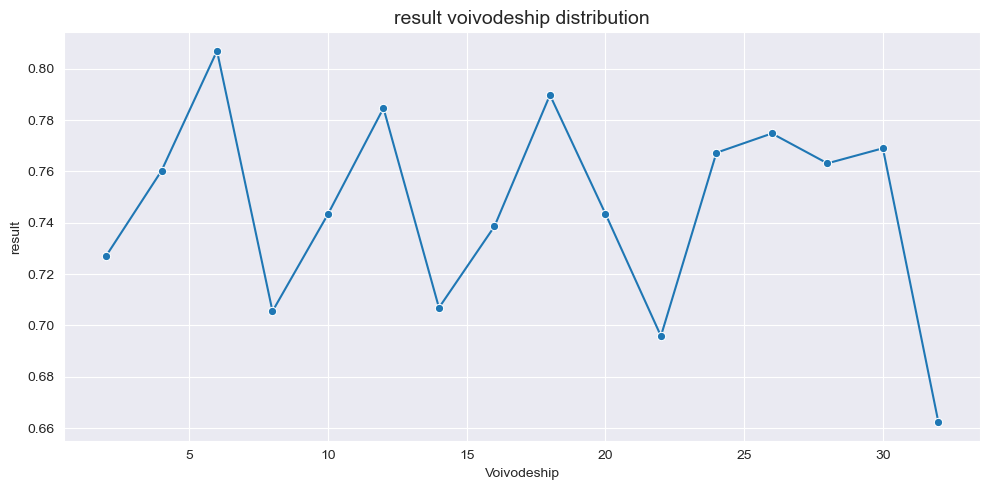

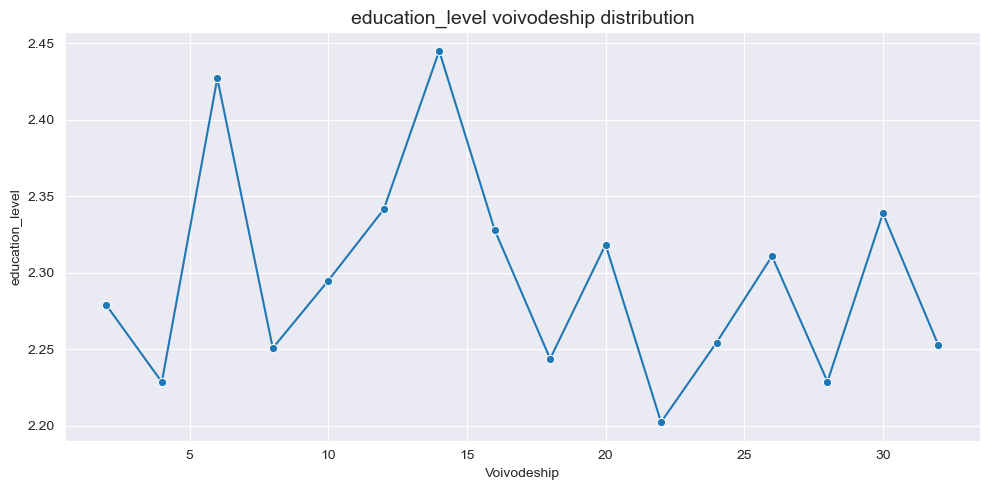

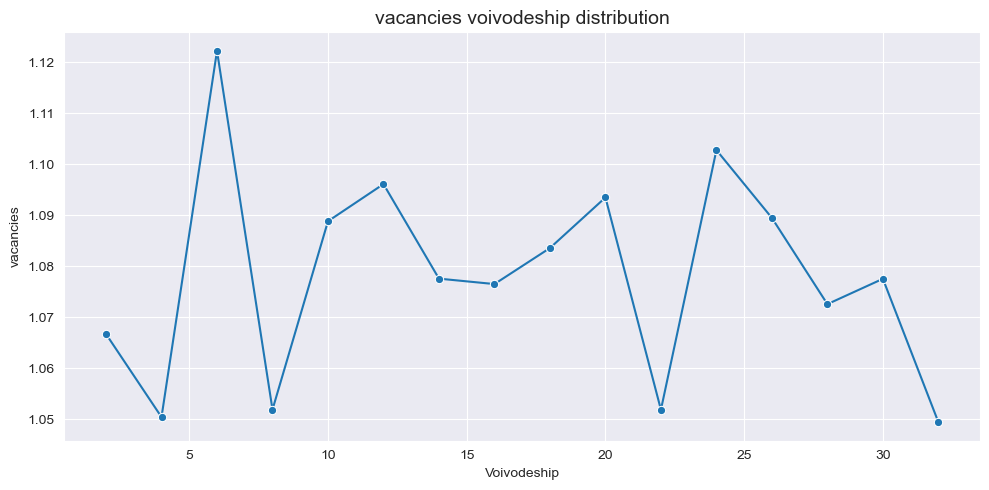

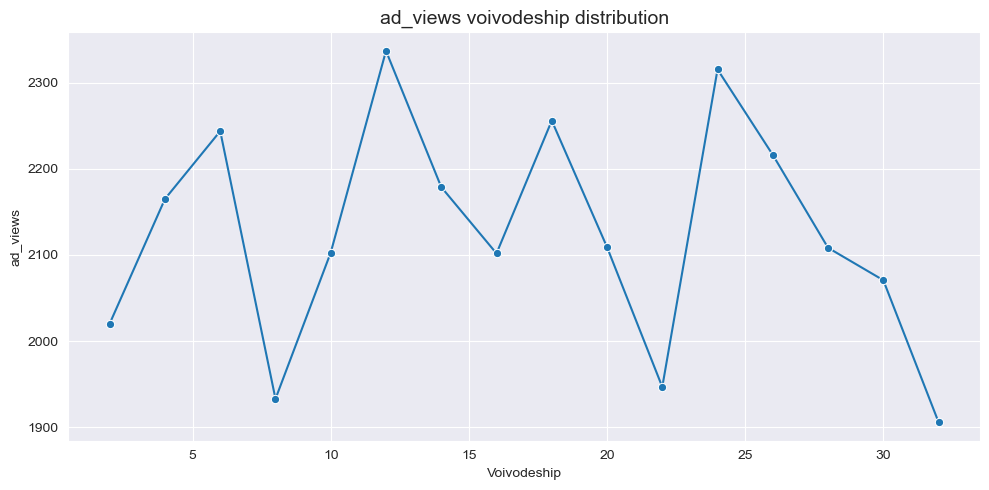

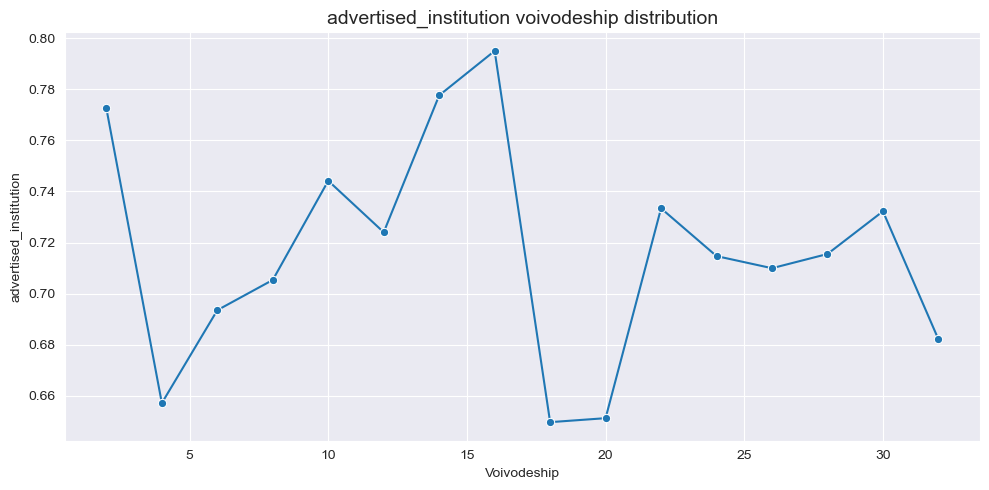

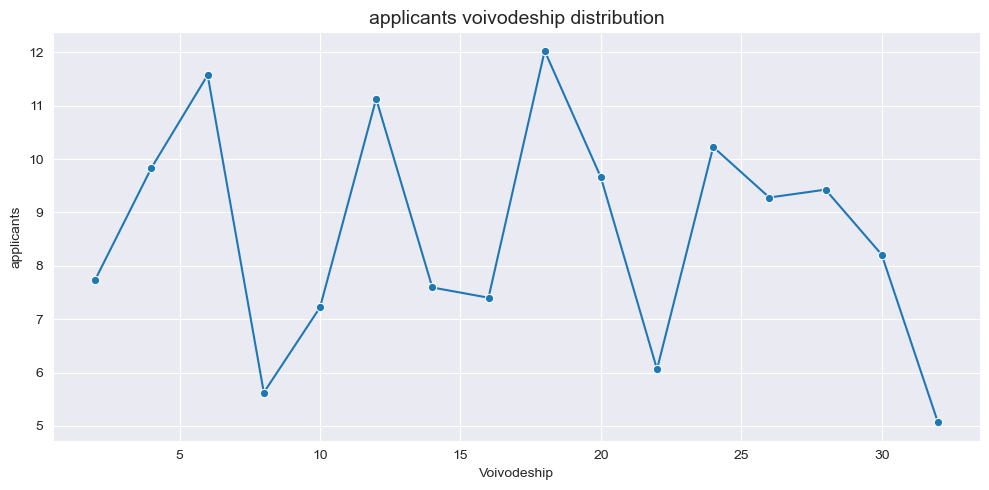

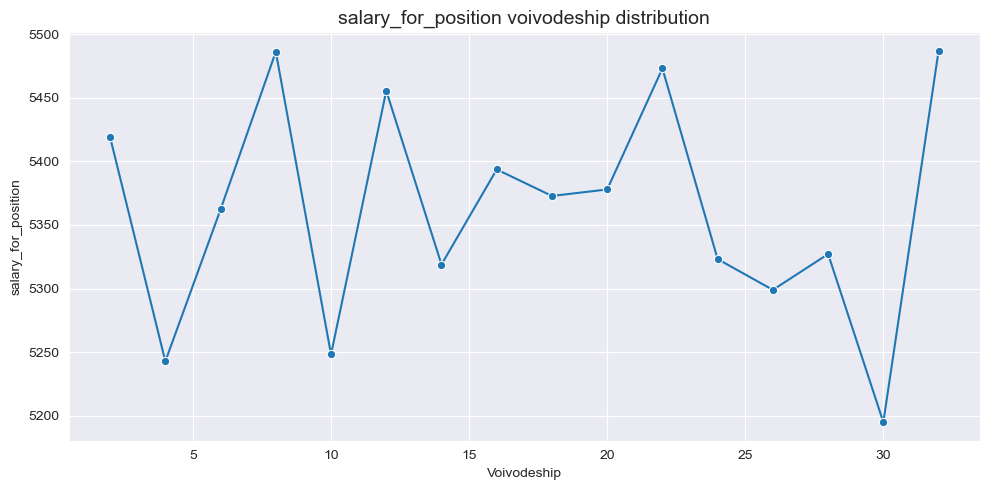

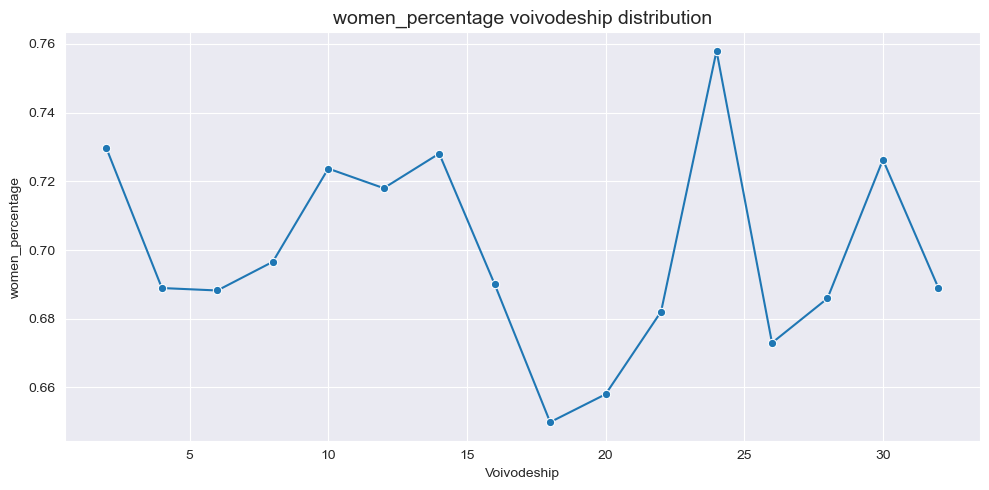

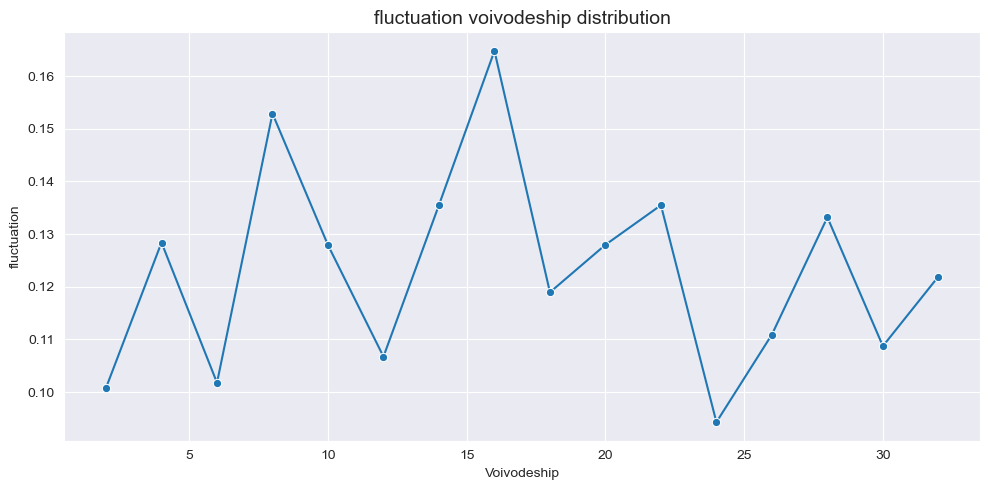

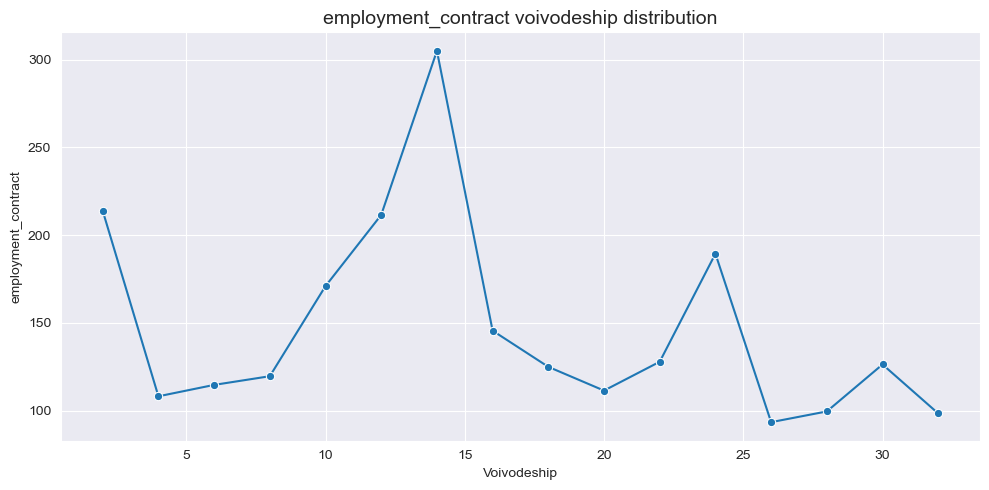

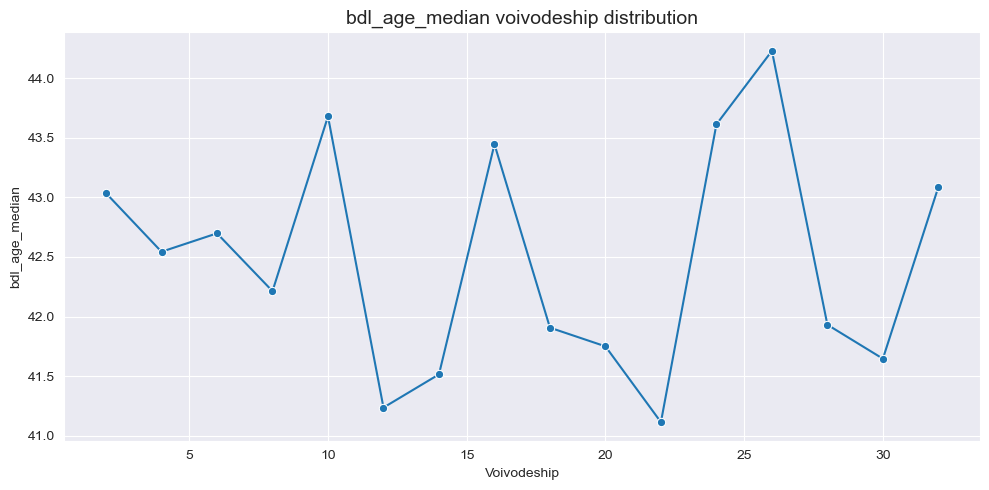

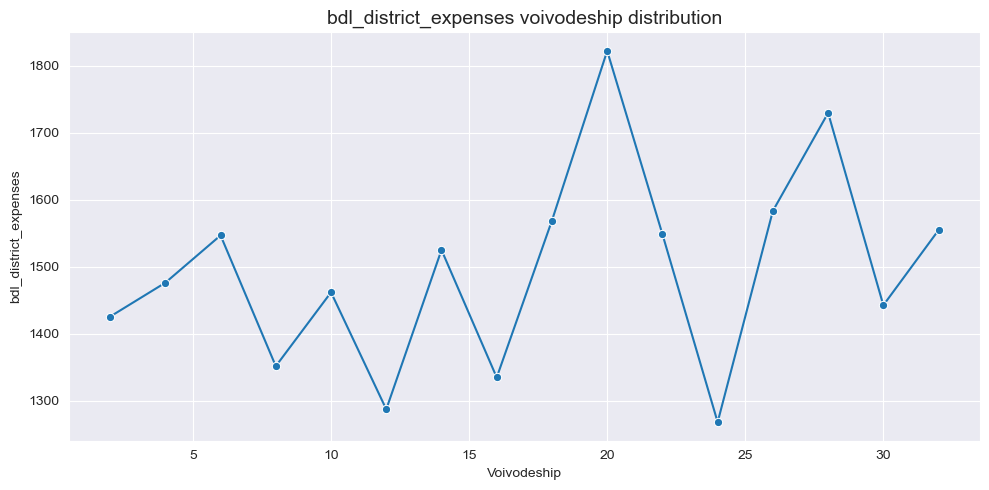

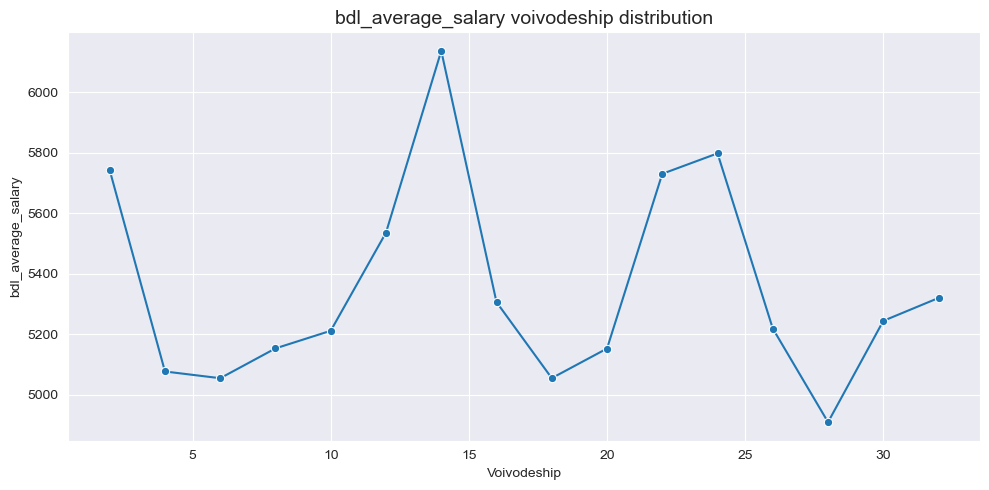

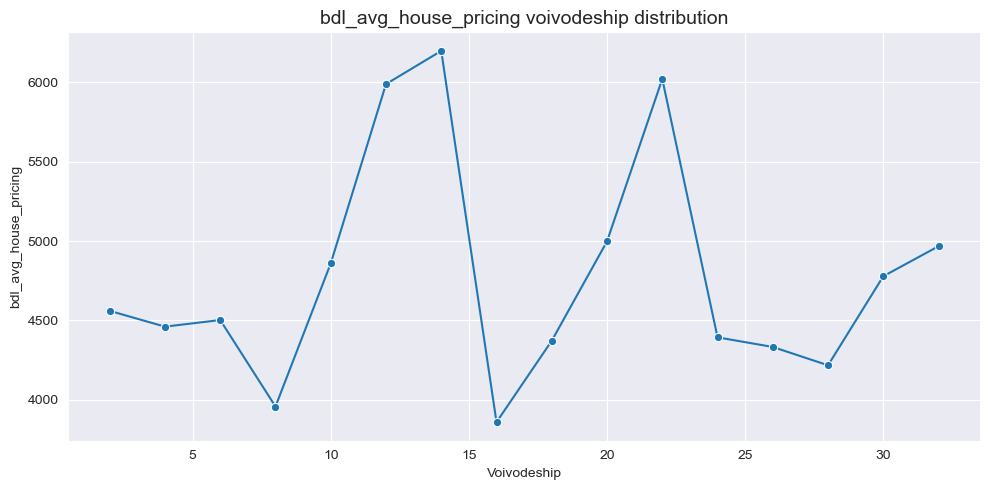

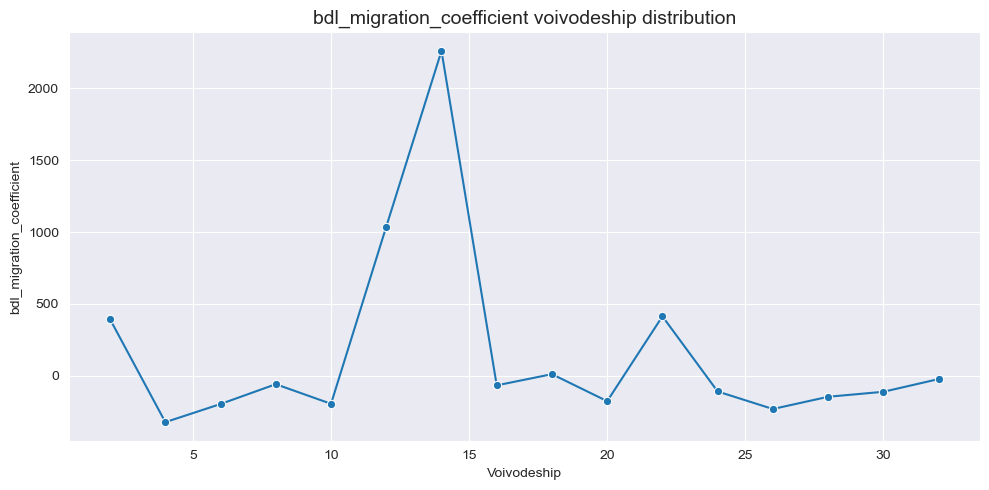

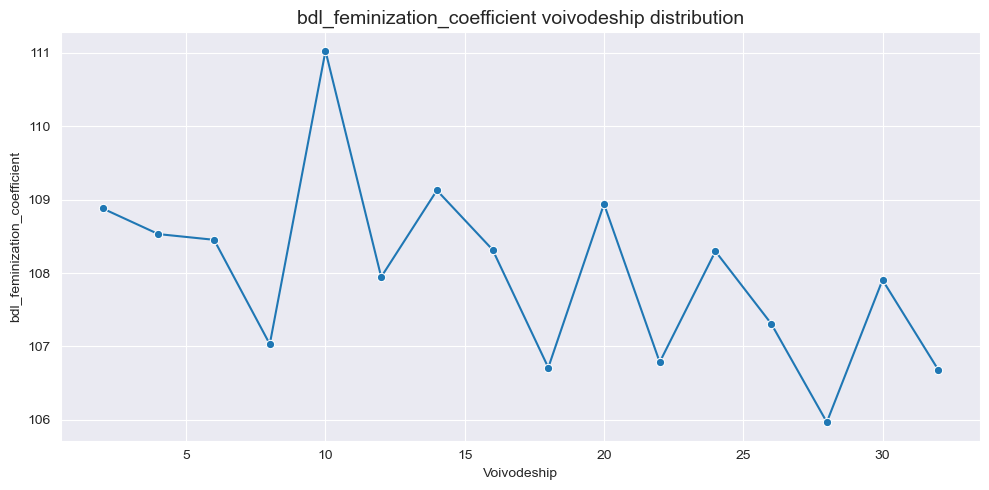

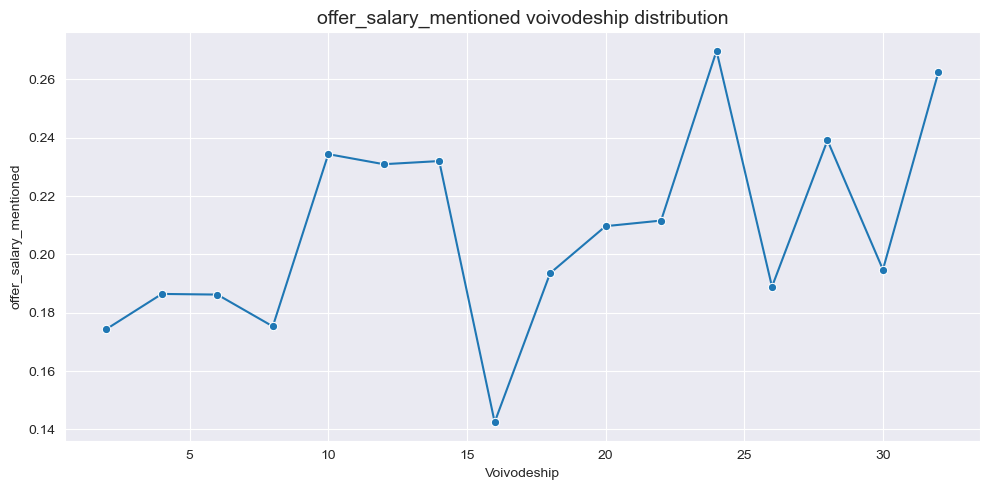

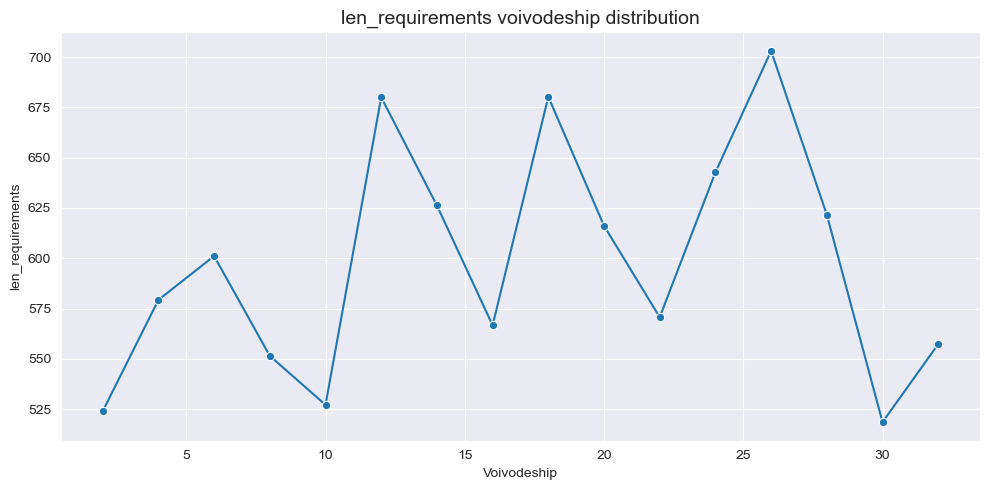

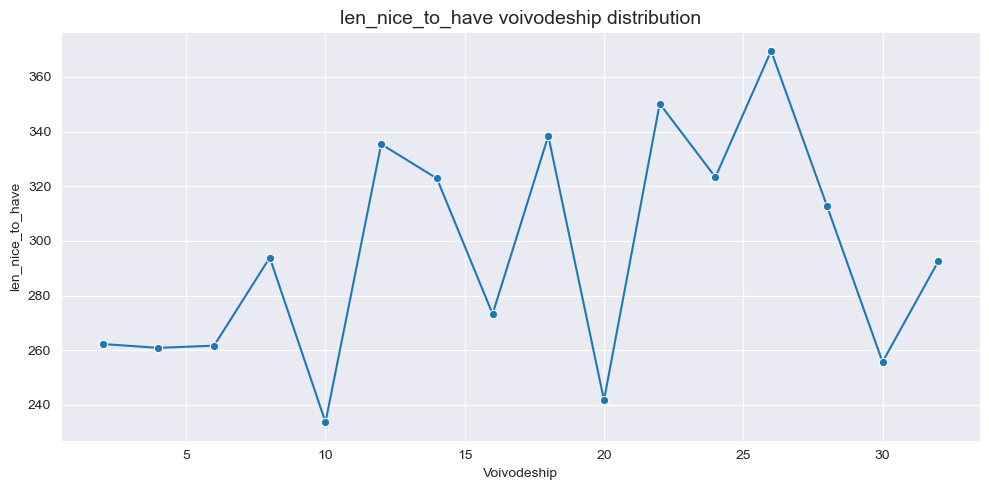

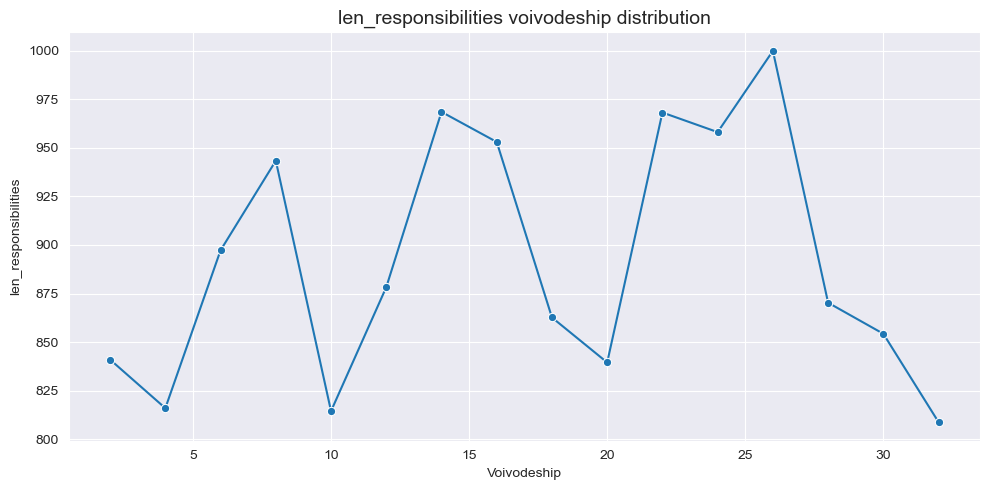

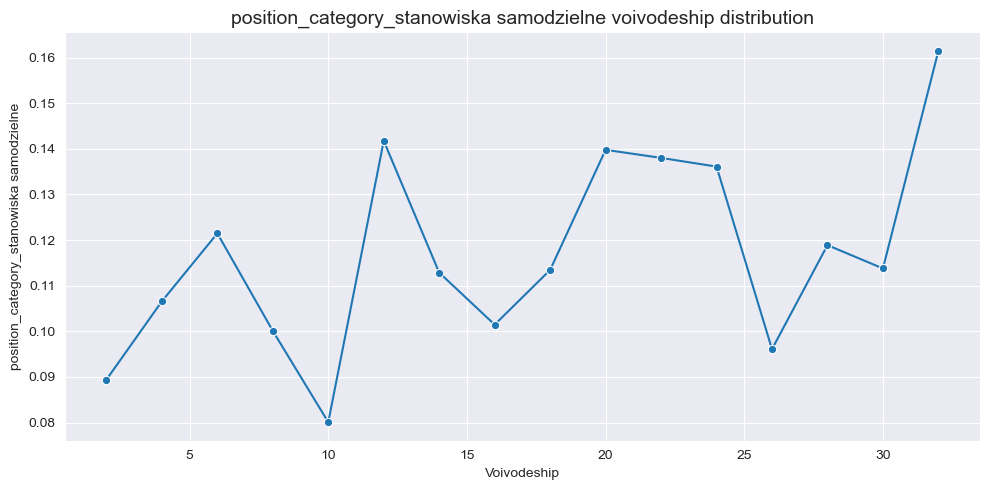

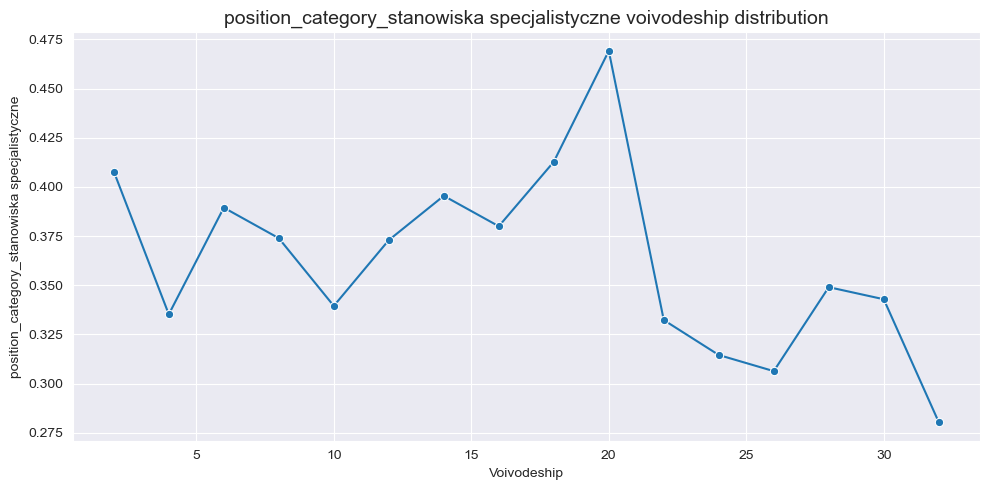

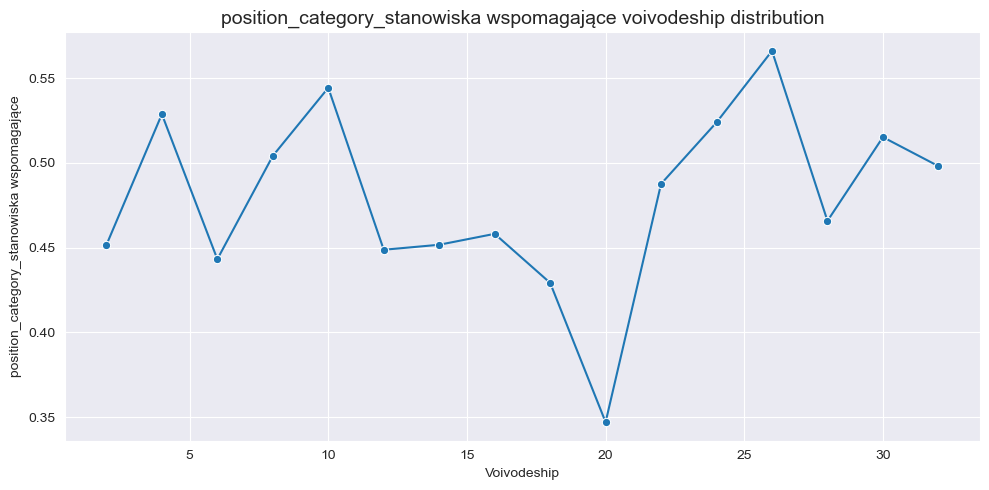

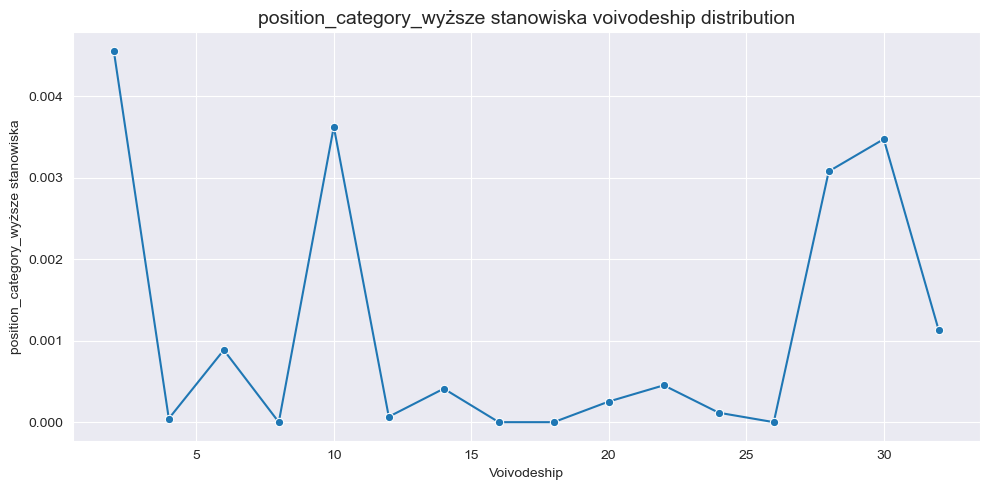

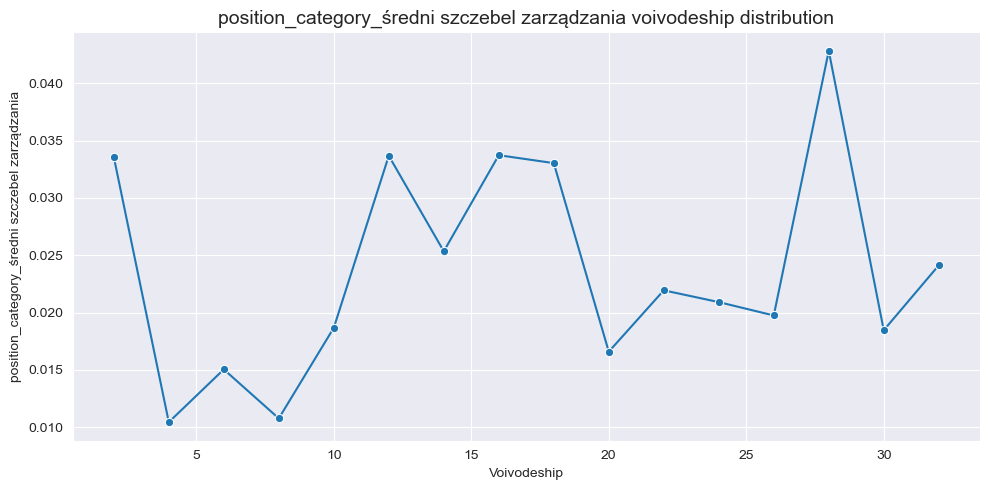

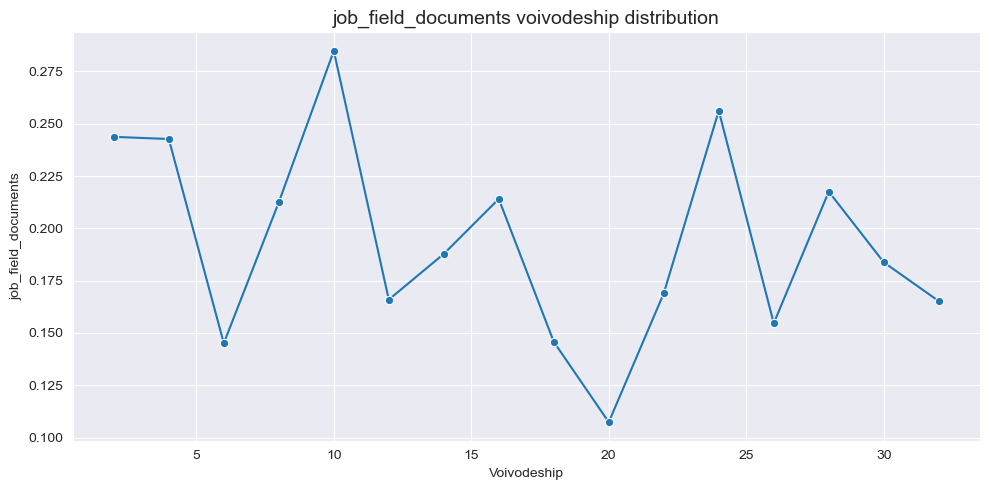

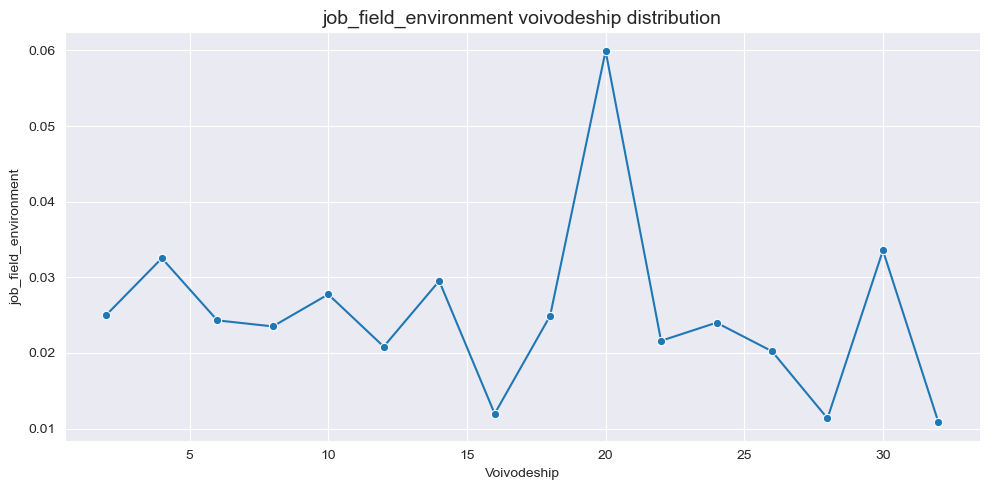

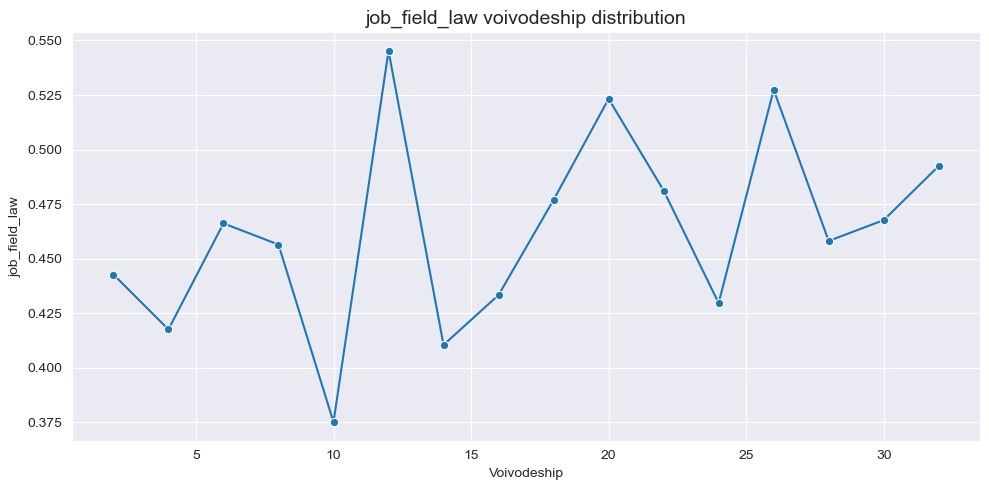

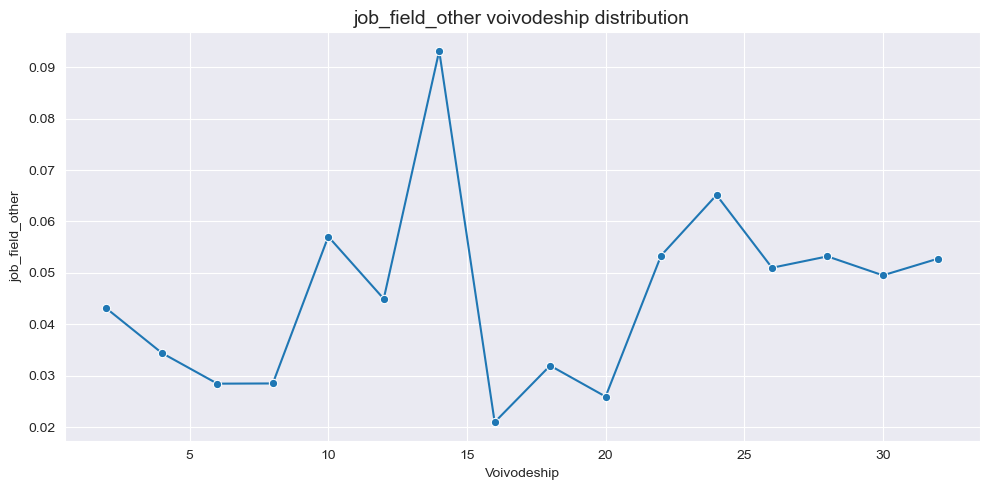

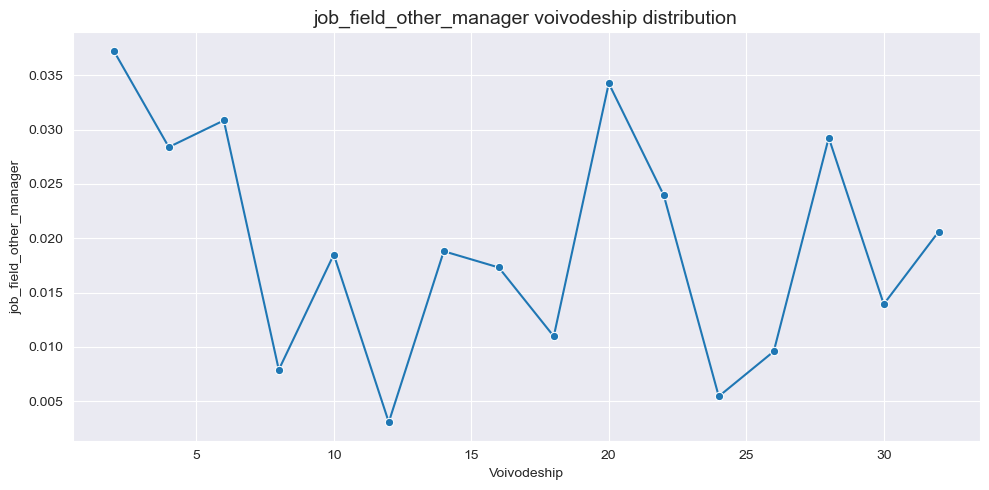

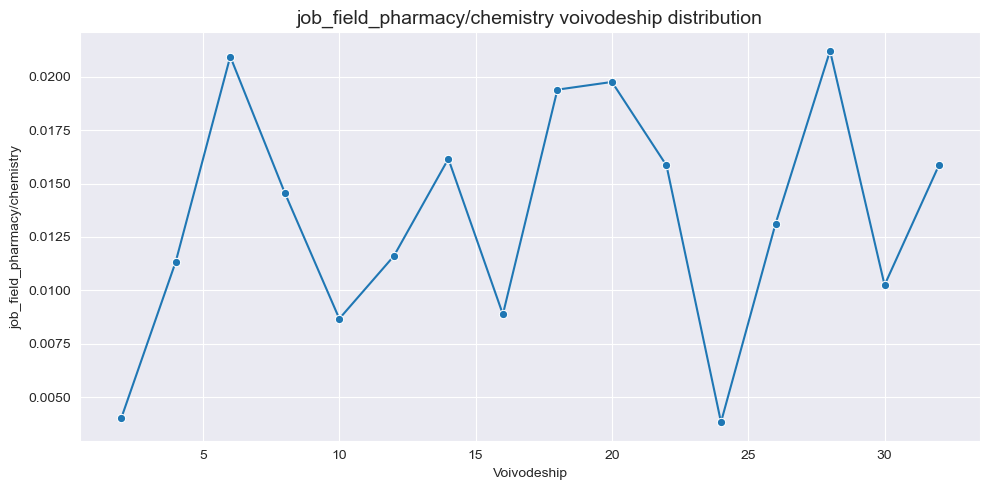

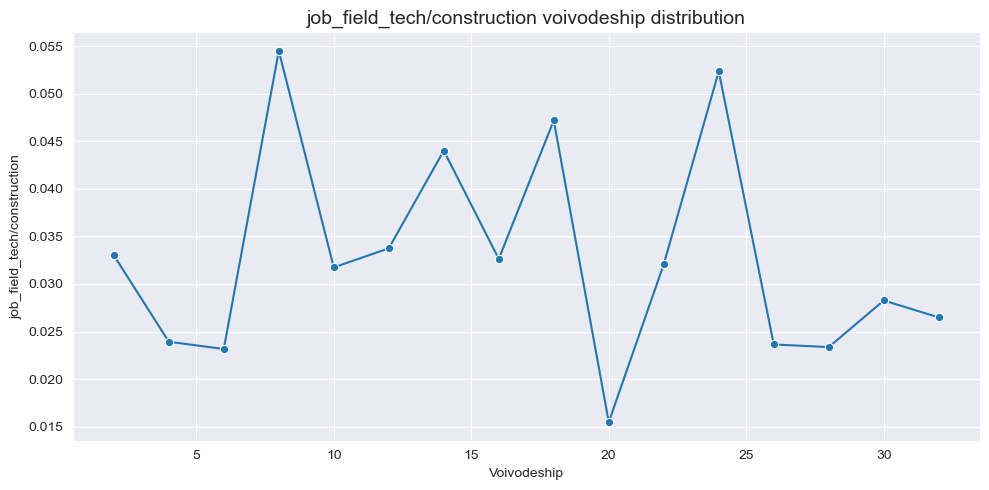

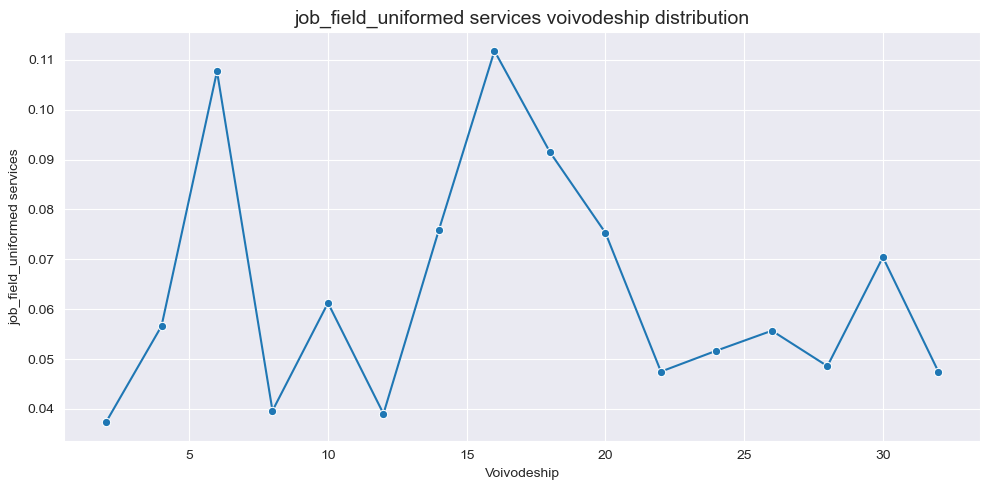

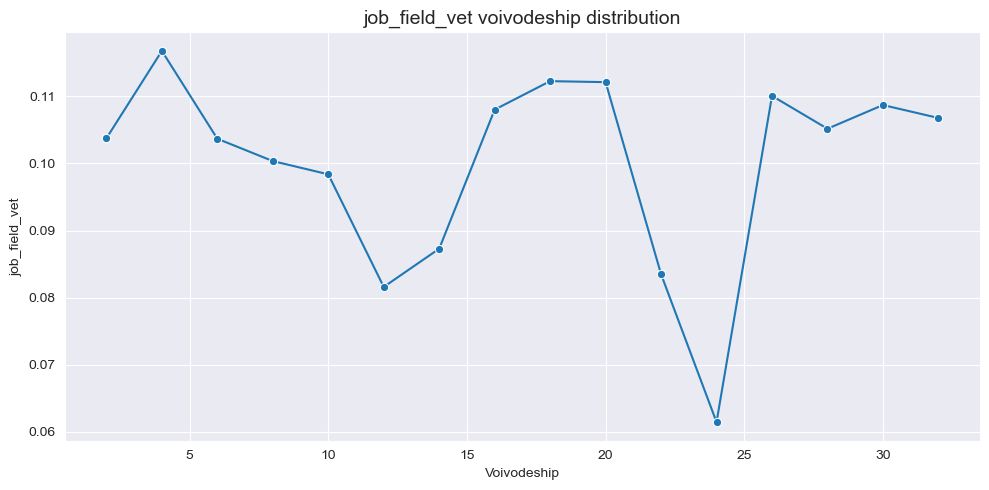

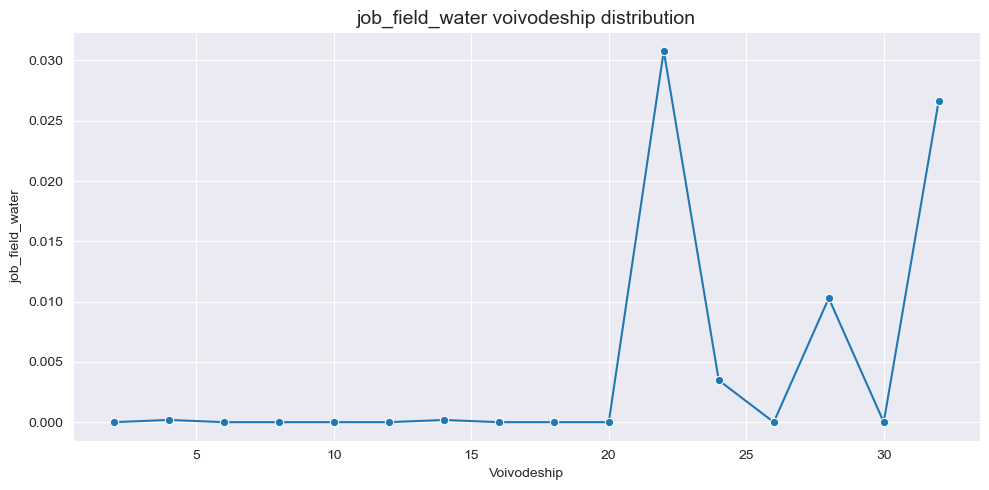

In [35]:
def plot_individual_time_series(dataframe):
    # Columns to exclude from plotting
    exclude_columns = ['work_time', 'year', 'district', 'voivodeship', 'institution']

    # Group by year and compute mean for numeric columns only.
    df_grouped = dataframe.groupby(['voivodeship']).mean(numeric_only=True)

    # Drop the excluded columns (if they exist).
    columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]

    # Plot each column individually
    for column in columns_to_plot:
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o')
        plt.title(f"{column} voivodeship distribution", fontsize=14)
        plt.xlabel("Voivodeship")
        plt.ylabel(column)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_individual_time_series(df_institution_level)

## Feature importance

### Initial assumptions

In [36]:
# As a result of the above analyses, I decided to exclude certain columns due to their low variability or low correlation.
cols_to_exclude = [
    "women_percentage",
    "bdl_feminization_coefficient",
    "len_nice_to_have",
    "work_time",
]

df_institution_level = df_institution_level.drop(columns=cols_to_exclude, axis=1)

### Lasso

In [37]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

In [38]:
df_for_lasso = df_institution_level.drop(columns=['institution', 'district', 'voivodeship', 'year', 'salary_for_position'], axis=1)
df_for_lasso = df_for_lasso.dropna()
X = df_for_lasso.drop('result', axis=1)
y = df_for_lasso['result']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)

importance = pd.Series(lasso.coef_, index=X.columns)
importance = importance.sort_values(key=abs, ascending=False)
print(importance)

job_field_vet                                   -0.094121
applicants                                       0.062945
ad_views                                         0.026639
job_field_uniformed services                     0.023173
position_category_stanowiska specjalistyczne    -0.018809
job_field_pharmacy/chemistry                    -0.017159
job_field_documents                              0.015057
employment_contract                              0.014882
offer_salary_mentioned                           0.014535
bdl_district_expenses                            0.012150
position_category_średni szczebel zarządzania    0.008432
job_field_other_manager                          0.008279
vacancies                                        0.007729
len_requirements                                -0.004474
bdl_average_salary                              -0.004214
fluctuation                                     -0.003350
job_field_other                                 -0.002935
position_categ

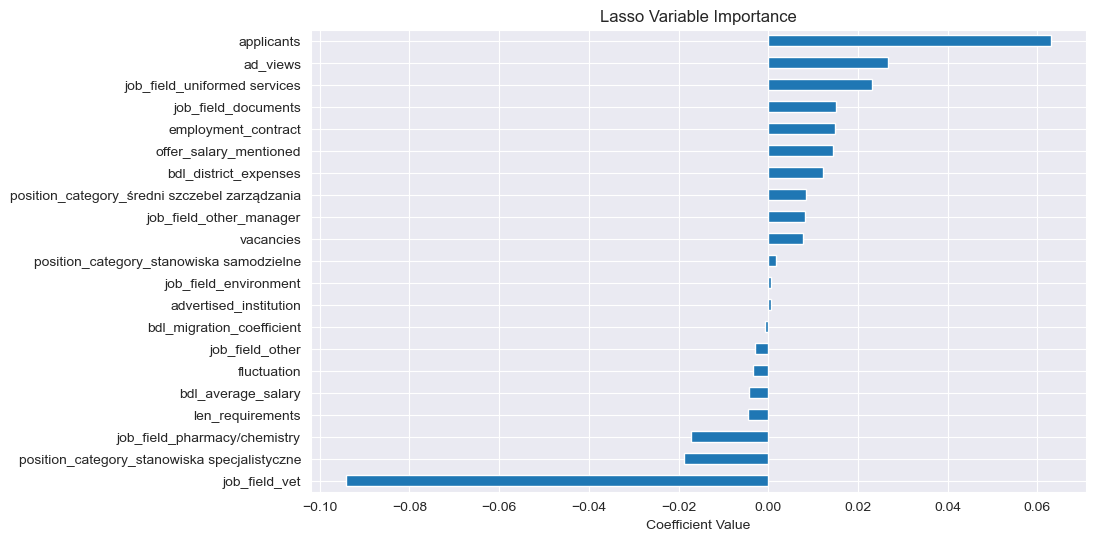

In [39]:
selected_features = importance[importance != 0].index.tolist()
df_institution_level = df_institution_level[selected_features]

importance[importance != 0].sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Lasso Variable Importance')
plt.xlabel('Coefficient Value')
plt.show()